# 22 — Profil Socio-Économique et Mobilité Douce

> **Dépendance** : `output/21_Classement_Villes_Mobilite_Douce/tables_csv/imd_classement.csv` (notebook 21)

---

## Objectif

Analyser les **inégalités sociales d'accès à la mobilité douce** en croisant le classement IMD (notebook 21)
avec les indicateurs socio-économiques des villes françaises issus de l'INSEE.

## Questions de Recherche

| N° | Question |
|:--:|:---------|
| 1 | Les villes les mieux dotées en SVLS sont-elles systématiquement les plus riches ? |
| 2 | Les villes à fort taux de pauvreté sont-elles pénalisées en mobilité douce ? |
| 3 | Quels facteurs socio-économiques **prédisent** le mieux l'IMD ? |
| 4 | Peut-on identifier des **déserts de mobilité sociale** ? |
| 5 | Certaines villes offrent-elles une mobilité **équitable** malgré leurs contraintes ? |

## Sources des Données Socio-Économiques

| Indicateur | Source | Année |
|:-----------|:-------|:------|
| Revenu médian par UC | INSEE Filosofi | 2020 |
| Taux de chômage | INSEE BPE local | 2021 T4 |
| Part des cadres et PIS | INSEE RP | 2019 |
| Part diplômés du supérieur | INSEE RP | 2019 |
| Part ménages sans voiture | INSEE RP | 2019 |
| Taux de pauvreté (seuil 60%) | INSEE Filosofi | 2020 |
| Part du vélo (dépl. domicile-travail) | ENTD + EMD locales | 2008–2020 |

> *Note : valeurs estimées à l'échelle de la commune/EPCI, arrondies aux unités significatives.*

## 1. Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

ROOT      = Path('../../')
NB21_OUT  = ROOT / 'output' / '21_Classement_Villes_Mobilite_Douce' / 'tables_csv'
NB20_OUT  = ROOT / 'output' / '20_GBFS_France_Collecte' / 'tables_csv'
OUTPUT_NB = ROOT / 'output' / '22_Profil_Socioeconomique_Mobilite'

(OUTPUT_NB / 'figures').mkdir(parents=True, exist_ok=True)
(OUTPUT_NB / 'tables_csv').mkdir(exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
CMAP_DIV  = plt.cm.RdYlGn    # divergent : rouge→vert
CMAP_SEQ  = plt.cm.Blues

print('Setup OK')
print(f'Output → {OUTPUT_NB}')

Setup OK
Output → ..\..\output\22_Profil_Socioeconomique_Mobilite


## 2. Données Socio-Économiques (INSEE)

Dataset intégré : 57 villes avec systèmes SVLS × 7 indicateurs socio-économiques.

In [2]:
# ── Données socio-économiques de base + sources externes optionnelles ─────────
# Base socio : récupérée depuis le dernier export consolidé du notebook 22.
# Sources externes : déposées en CSV dans data/external/mobility_sources/.

BASE_SOCIO_PATH = OUTPUT_NB / 'tables_csv' / 'profil_complet_villes.csv'
EXTERNAL_SRC_DIR = ROOT / 'data' / 'external' / 'mobility_sources'

COLS_SOCIO = [
    'revenu_median_uc', 'taux_chomage', 'part_cadres',
    'part_diplomes_sup', 'part_sans_voiture',
    'taux_pauvrete', 'part_velo'
]

required_base_cols = ['city'] + COLS_SOCIO

if not BASE_SOCIO_PATH.exists():
    raise FileNotFoundError(
        f"Base socio introuvable: {BASE_SOCIO_PATH}. "
        "Exécuter une fois le notebook 22 existant pour créer profil_complet_villes.csv."
    )

df_base = pd.read_csv(BASE_SOCIO_PATH)
missing = [c for c in required_base_cols if c not in df_base.columns]
if missing:
    raise ValueError(
        f"Colonnes manquantes dans {BASE_SOCIO_PATH.name}: {missing}"
    )

df_socio = (
    df_base[required_base_cols]
    .dropna(subset=['city'])
    .drop_duplicates(subset=['city'])
    .copy()
)

def _norm_city(series: pd.Series) -> pd.Series:
    return (
        series.astype(str)
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True)
    )

df_socio['city'] = _norm_city(df_socio['city'])

EXTERNAL_SOURCES = {
    'fub_score_2023': {
        'file': EXTERNAL_SRC_DIR / 'fub_barometre_2023_city_scores.csv',
        'columns': ['city', 'fub_score_2023', 'fub_rank_2023']
    },
    'emp_part_velo_2019': {
        'file': EXTERNAL_SRC_DIR / 'emp_2019_city_modal_share.csv',
        'columns': ['city', 'emp_part_velo_2019']
    },
    'infra_cyclable_km_per_km2': {
        'file': EXTERNAL_SRC_DIR / 'cerema_cycling_infra_city.csv',
        'columns': ['city', 'infra_cyclable_km', 'infra_cyclable_km_per_km2']
    },
    'gtfs_stops_within_300m_pct': {
        'file': EXTERNAL_SRC_DIR / 'gtfs_intermodal_city.csv',
        'columns': ['city', 'gtfs_stops_within_300m_pct']
    },
    'eco_avg_daily_bike_counts': {
        'file': EXTERNAL_SRC_DIR / 'eco_compteurs_city_usage.csv',
        'columns': ['city', 'eco_avg_daily_bike_counts']
    },
    'baac_accidents_cyclistes_per_100k': {
        'file': EXTERNAL_SRC_DIR / 'baac_cyclist_accidents_city.csv',
        'columns': ['city', 'baac_accidents_cyclistes', 'baac_accidents_cyclistes_per_100k']
    },
}

loaded_sources = []
missing_sources = []

for src_name, cfg in EXTERNAL_SOURCES.items():
    src_path = cfg['file']
    if not src_path.exists():
        missing_sources.append(src_path.name)
        continue

    df_ext = pd.read_csv(src_path)
    cols_available = [c for c in cfg['columns'] if c in df_ext.columns]
    if 'city' not in cols_available:
        missing_sources.append(f"{src_path.name} (colonne city manquante)")
        continue

    df_ext = df_ext[cols_available].copy()
    df_ext['city'] = _norm_city(df_ext['city'])
    df_ext = df_ext.dropna(subset=['city']).drop_duplicates(subset=['city'])

    df_socio = df_socio.merge(df_ext, on='city', how='left')
    loaded_sources.append(src_path.name)

coverage_rows = []
for c in df_socio.columns:
    if c == 'city':
        continue
    coverage_rows.append({
        'variable': c,
        'non_null_count': int(df_socio[c].notna().sum()),
        'coverage_pct': round(100 * df_socio[c].notna().mean(), 2),
    })

df_coverage = pd.DataFrame(coverage_rows).sort_values(
    by=['coverage_pct', 'variable'], ascending=[False, True]
)
df_coverage.to_csv(OUTPUT_NB / 'tables_csv' / 'source_externe_couverture.csv', index=False)

print(f"Données socio-économiques de base : {len(df_socio)} villes")
print(f"Sources externes chargées        : {len(loaded_sources)}")
if loaded_sources:
    for s in loaded_sources:
        print(f"  ✓ {s}")
if missing_sources:
    print(f"Sources externes absentes/invalides: {len(missing_sources)}")
    for s in missing_sources:
        print(f"  - {s}")

print("\nAperçu statistique (variables socio de base) :")
print(df_socio[COLS_SOCIO].describe().round(1).to_string())
print("\nRapport de couverture exporté : source_externe_couverture.csv")

Données socio-économiques de base : 62 villes
Sources externes chargées        : 6
  ✓ fub_barometre_2023_city_scores.csv
  ✓ emp_2019_city_modal_share.csv
  ✓ cerema_cycling_infra_city.csv
  ✓ gtfs_intermodal_city.csv
  ✓ eco_compteurs_city_usage.csv
  ✓ baac_cyclist_accidents_city.csv

Aperçu statistique (variables socio de base) :
       revenu_median_uc  taux_chomage  part_cadres  part_diplomes_sup  part_sans_voiture  taux_pauvrete  part_velo
count              62.0          62.0         62.0               62.0               62.0           62.0       62.0
mean            19075.8          12.6         17.1               38.8               23.8           21.4        2.2
std              2246.8           3.1          4.6                7.4                7.8            4.9        1.7
min             14000.0           7.5         11.0               28.0               15.0           14.0        0.5
25%             17625.0          10.5         14.0               33.2               18.5 

## 3. Fusion IMD × Socio-Économique

In [3]:
df_imd = pd.read_csv(NB21_OUT / 'imd_classement.csv')
df_imd['city'] = df_imd['city'].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)

df_all = df_imd.merge(df_socio, on='city', how='left')

# Villes avec données socio minimales
df_m = df_all.dropna(subset=['revenu_median_uc']).copy()

# Indicateurs dérivés
df_m['fragilite_sociale'] = (
    df_m['taux_pauvrete'] * 0.50 +
    df_m['taux_chomage']  * 0.30 +
    (100 - df_m['part_cadres']) * 0.20
) / 100  # → 0-1, 1 = forte fragilité

df_m['niveau_socio'] = (
    df_m['revenu_median_uc'] / df_m['revenu_median_uc'].max() * 0.40 +
    df_m['part_cadres'] / df_m['part_cadres'].max() * 0.30 +
    df_m['part_diplomes_sup'] / df_m['part_diplomes_sup'].max() * 0.30
)  # → 0-1, 1 = très favorisé

print(f'Villes avec données complètes : {len(df_m)} / {len(df_imd)}')
print(f'\nTop 5 IMD :')
print(df_m[['city', 'IMD', 'revenu_median_uc', 'taux_chomage', 'taux_pauvrete']]
      .head(5).to_string(index=False))
print(f'\nCorr. Spearman IMD × revenu médian : ',
      round(spearmanr(df_m['IMD'], df_m['revenu_median_uc'])[0], 3))
print(f'Corr. Spearman IMD × taux chômage  : ',
      round(spearmanr(df_m['IMD'], df_m['taux_chomage'])[0], 3))
print(f'Corr. Spearman IMD × taux pauvreté : ',
      round(spearmanr(df_m['IMD'], df_m['taux_pauvrete'])[0], 3))

extra_cols = [
    'fub_score_2023',
    'emp_part_velo_2019',
    'infra_cyclable_km_per_km2',
    'gtfs_stops_within_300m_pct',
    'eco_avg_daily_bike_counts',
    'baac_accidents_cyclistes_per_100k',
]
extra_cols_present = [c for c in extra_cols if c in df_m.columns]
if extra_cols_present:
    print('\nCouverture des sources externes (villes non-null) :')
    for c in extra_cols_present:
        n = int(df_m[c].notna().sum())
        print(f'  - {c}: {n}/{len(df_m)}')

Villes avec données complètes : 62 / 62

Top 5 IMD :
     city    IMD  revenu_median_uc  taux_chomage  taux_pauvrete
 Bordeaux 0.7872           20500.0          10.5           18.0
Marseille 0.7547           16500.0          17.0           30.0
   Nantes 0.6624           22000.0           8.5           14.0
     Lyon 0.6602           22500.0           9.5           18.0
   Rennes 0.6213           22000.0           8.0           15.0

Corr. Spearman IMD × revenu médian :  0.295
Corr. Spearman IMD × taux chômage  :  -0.27
Corr. Spearman IMD × taux pauvreté :  -0.172

Couverture des sources externes (villes non-null) :
  - fub_score_2023: 34/62
  - emp_part_velo_2019: 46/62
  - infra_cyclable_km_per_km2: 45/62
  - gtfs_stops_within_300m_pct: 0/62
  - eco_avg_daily_bike_counts: 26/62
  - baac_accidents_cyclistes_per_100k: 46/62


## 4. Portrait Statistique — Distribution des Villes SVLS

Les villes dotées de SVLS sont-elles représentatives de la France ou biaisées socialement ?

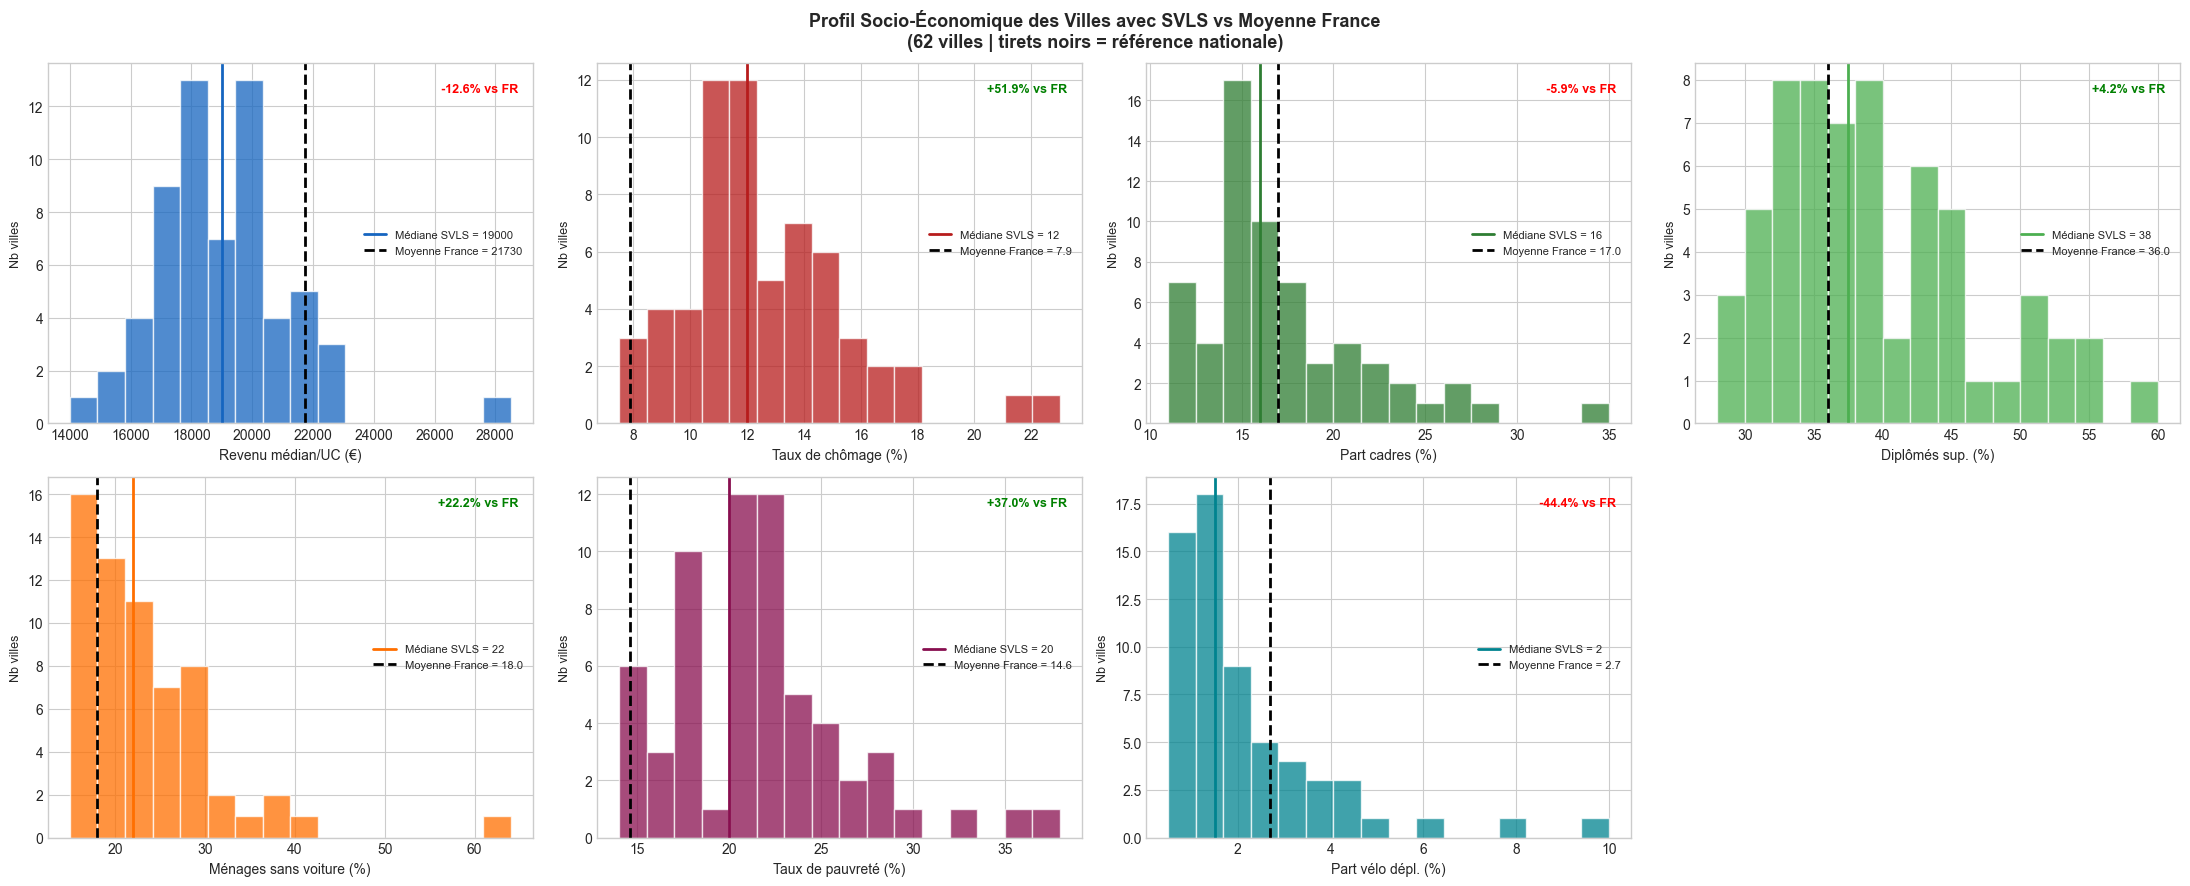

Villes SVLS vs France (médiane) :
  Revenu médian/UC (€)               : 19000.0  (-12.6% vs France)
  Taux de chômage (%)                : 12.0  (+51.9% vs France)
  Part cadres (%)                    : 16.0  (-5.9% vs France)
  Diplômés sup. (%)                  : 37.5  (+4.2% vs France)
  Ménages sans voiture (%)           : 22.0  (+22.2% vs France)
  Taux de pauvreté (%)               : 20.0  (+37.0% vs France)
  Part vélo dépl. (%)                : 1.5  (-44.4% vs France)


In [4]:
# Références nationales France (INSEE 2020)
FRANCE_REF = {
    'revenu_median_uc':   21_730,
    'taux_chomage':         7.9,
    'part_cadres':         17.0,
    'part_diplomes_sup':   36.0,
    'part_sans_voiture':   18.0,
    'taux_pauvrete':       14.6,
    'part_velo':            2.7,
}

fig, axes = plt.subplots(2, 4, figsize=(22, 9))
axes = axes.flat

VAR_LABELS = {
    'revenu_median_uc':   'Revenu médian/UC (€)',
    'taux_chomage':       'Taux de chômage (%)',
    'part_cadres':        'Part cadres (%)',
    'part_diplomes_sup':  'Diplômés sup. (%)',
    'part_sans_voiture':  'Ménages sans voiture (%)',
    'taux_pauvrete':      'Taux de pauvreté (%)',
    'part_velo':          'Part vélo dépl. (%)',
}
VAR_COLORS = {
    'revenu_median_uc':   '#1565C0',
    'taux_chomage':       '#B71C1C',
    'part_cadres':        '#2E7D32',
    'part_diplomes_sup':  '#4CAF50',
    'part_sans_voiture':  '#FF6F00',
    'taux_pauvrete':      '#880E4F',
    'part_velo':          '#00838F',
}

for ax, (col, label) in zip(axes, VAR_LABELS.items()):
    vals = df_m[col].dropna()
    color = VAR_COLORS[col]

    ax.hist(vals, bins=16, color=color, alpha=0.75, edgecolor='white')

    # Médiane villes SVLS
    med = vals.median()
    ax.axvline(med, color=color, lw=2, ls='-',
               label=f'Médiane SVLS = {med:.0f}')

    # Référence nationale
    ref = FRANCE_REF.get(col)
    if ref:
        ax.axvline(ref, color='black', lw=2, ls='--',
                   label=f'Moyenne France = {ref}')
        ecart = (med - ref) / ref * 100
        sign  = '+' if ecart > 0 else ''
        ax.text(0.97, 0.92, f'{sign}{ecart:.1f}% vs FR',
                transform=ax.transAxes, ha='right', fontsize=9,
                color='green' if ecart > 0 else 'red', fontweight='bold')

    ax.set_xlabel(label, fontsize=10)
    ax.set_ylabel('Nb villes', fontsize=9)
    ax.legend(fontsize=8, framealpha=0.9)

# Supprimer le dernier ax vide
axes[-1].axis('off')

plt.suptitle(
    f'Profil Socio-Économique des Villes avec SVLS vs Moyenne France\n'
    f'({len(df_m)} villes | tirets noirs = référence nationale)',
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '01_portrait_socio.png', dpi=150, bbox_inches='tight')
plt.show()

print('Villes SVLS vs France (médiane) :')
for col, label in VAR_LABELS.items():
    med = df_m[col].median()
    ref = FRANCE_REF.get(col, np.nan)
    ecart = (med - ref) / ref * 100 if ref else np.nan
    print(f'  {label:35s}: {med:.1f}  ({ecart:+.1f}% vs France)')

## 5. Corrélations IMD × Variables Socio-Économiques

Six scatter plots avec corrélation de Spearman — identification des déterminants de l'IMD.

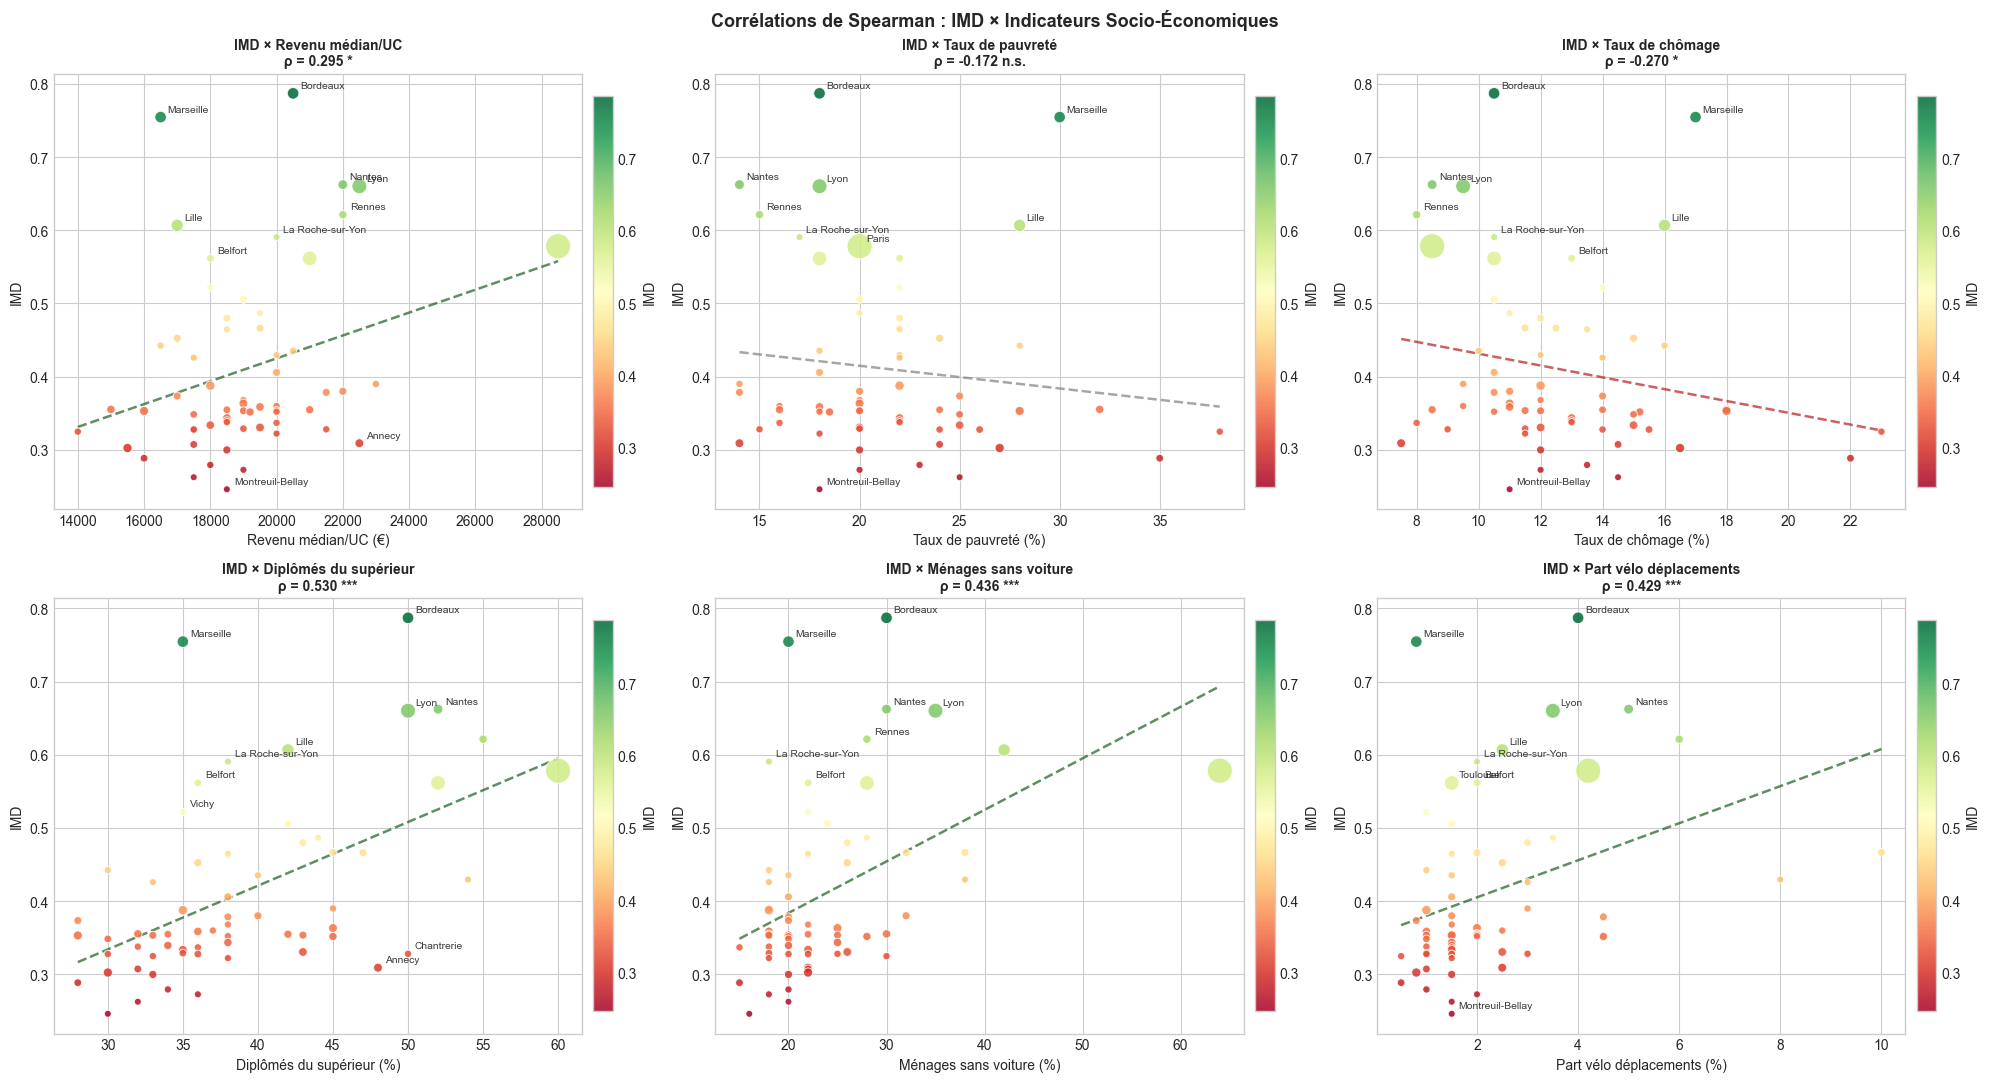

Tableau des corrélations Spearman avec IMD :
                  Variable      ρ      p Sig.
      Revenu médian/UC (€)  0.295 0.0199    *
      Taux de pauvreté (%) -0.172 0.1812 n.s.
       Taux de chômage (%) -0.270 0.0339    *
 Diplômés du supérieur (%)  0.530 0.0000  ***
  Ménages sans voiture (%)  0.436 0.0004  ***
Part vélo déplacements (%)  0.429 0.0005  ***


In [5]:
fig, axes = plt.subplots(2, 3, figsize=(20, 11))

scatter_vars = [
    ('revenu_median_uc',  'Revenu médian/UC (€)',       'positive'),
    ('taux_pauvrete',     'Taux de pauvreté (%)',        'negative'),
    ('taux_chomage',      'Taux de chômage (%)',         'negative'),
    ('part_diplomes_sup', 'Diplômés du supérieur (%)',   'positive'),
    ('part_sans_voiture', 'Ménages sans voiture (%)',    'neutral'),
    ('part_velo',         'Part vélo déplacements (%)', 'positive'),
]

for ax, (col, label, direction) in zip(axes.flat, scatter_vars):
    df_plot = df_m.dropna(subset=[col, 'IMD']).copy()
    r, p = spearmanr(df_plot[col], df_plot['IMD'])

    # Couleur points : IMD
    norm = plt.Normalize(df_plot['IMD'].min(), df_plot['IMD'].max())
    sc = ax.scatter(
        df_plot[col], df_plot['IMD'],
        c=df_plot['IMD'], cmap=CMAP_DIV, norm=norm,
        s=df_plot['n_dock'] / 5 + 25,
        alpha=0.85, edgecolors='white', linewidths=0.7, zorder=3
    )
    plt.colorbar(sc, ax=ax, label='IMD', fraction=0.035, pad=0.02)

    # Droite de tendance
    z = np.polyfit(df_plot[col], df_plot['IMD'], 1)
    p_line = np.poly1d(z)
    x_range = np.linspace(df_plot[col].min(), df_plot[col].max(), 100)
    line_color = '#1B5E20' if r > 0.2 else ('#B71C1C' if r < -0.2 else 'gray')
    ax.plot(x_range, p_line(x_range), '--', color=line_color, lw=1.8, alpha=0.7)

    # Annoter les outliers
    df_plot['residual'] = df_plot['IMD'] - p_line(df_plot[col])
    thresh = df_plot['residual'].std() * 1.3
    for _, row in df_plot[abs(df_plot['residual']) > thresh].iterrows():
        ax.annotate(row['city'], (row[col], row['IMD']),
                    textcoords='offset points', xytext=(5, 4),
                    fontsize=7.5, alpha=0.9)

    sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'n.s.'))
    ax.set_xlabel(label, fontsize=10)
    ax.set_ylabel('IMD', fontsize=10)
    ax.set_title(
        f'IMD × {label.split(" (")[0]}\nρ = {r:.3f} {sig}',
        fontsize=10, fontweight='bold'
    )

plt.suptitle('Corrélations de Spearman : IMD × Indicateurs Socio-Économiques',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '02_correlations_socio_IMD.png', dpi=150, bbox_inches='tight')
plt.show()

print('Tableau des corrélations Spearman avec IMD :')
corr_rows = []
for col, label, _ in scatter_vars:
    df_tmp = df_m.dropna(subset=[col, 'IMD'])
    r, p = spearmanr(df_tmp[col], df_tmp['IMD'])
    sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'n.s.'))
    corr_rows.append({'Variable': label, 'ρ': round(r, 3), 'p': round(p, 4), 'Sig.': sig})
print(pd.DataFrame(corr_rows).to_string(index=False))

## 6. Analyse en Quadrants — Justice Socio-Mobilité

**Quatre profils de villes** selon leur niveau socio-économique et leur dotation en SVLS.

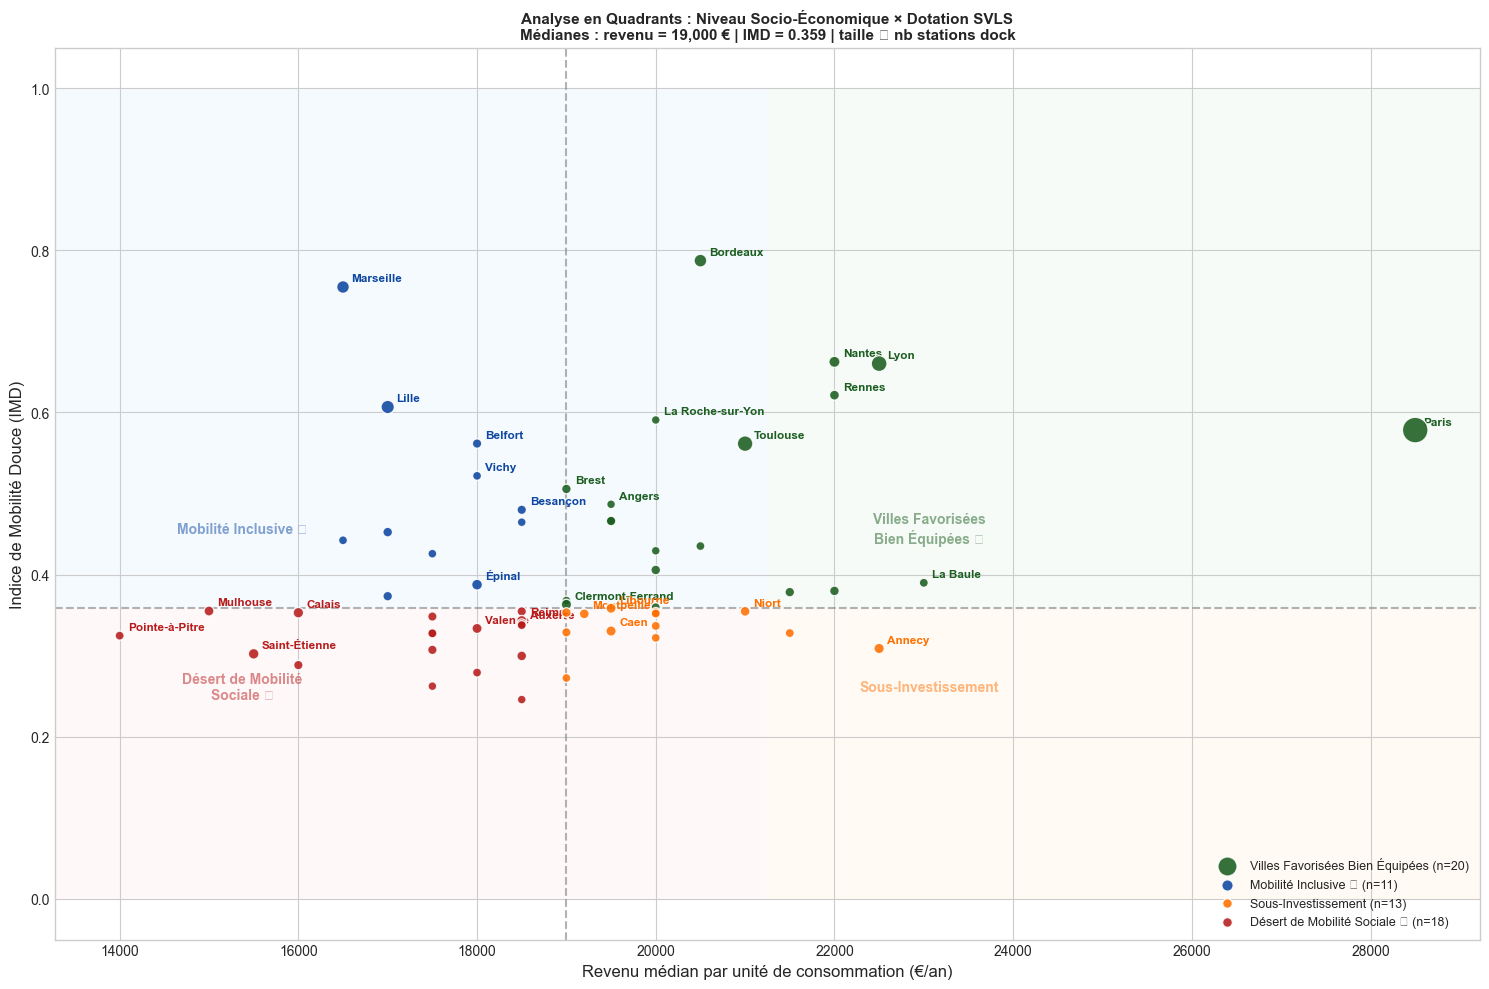

=== Répartition par quadrant ===
  Désert de Mobilité Sociale ⚠            : 18 villes  ex: Saint-Étienne, Calais, Valence, Reims
  Mobilité Inclusive ★                    : 11 villes  ex: Lille, Marseille, Épinal, Amiens
  Sous-Investissement                     : 13 villes  ex: Annecy, Caen, Libourne, Montpellier
  Villes Favorisées Bien Équipées         : 20 villes  ex: Paris, Lyon, Toulouse, Bordeaux


In [6]:
REV_THRESHOLD = df_m['revenu_median_uc'].median()
IMD_THRESHOLD = df_m['IMD'].median()

QUADRANT_CONFIG = [
    # (label, x>xmed, y>ymed, color, desc)
    ('Villes Favorisées\nBien Équipées',  True,  True,  '#1B5E20',
     'Riches + bon IMD — standard attendu, moins méritoire'),
    ('Mobilité Inclusive ★',              False, True,  '#0D47A1',
     'Revenus modestes + bon IMD — effort remarquable'),
    ('Sous-Investissement',               True,  False, '#FF6F00',
     'Villes riches mais IMD faible — potentiel non exploité'),
    ('Désert de Mobilité Sociale ⚠',     False, False, '#B71C1C',
     'Revenus faibles + mauvais IMD — priorité politique absolue'),
]

def assign_quadrant(row):
    high_rev = row['revenu_median_uc'] >= REV_THRESHOLD
    high_imd = row['IMD'] >= IMD_THRESHOLD
    if     high_rev and     high_imd: return 'Villes Favorisées\nBien Équipées'
    if not high_rev and     high_imd: return 'Mobilité Inclusive ★'
    if     high_rev and not high_imd: return 'Sous-Investissement'
    return 'Désert de Mobilité Sociale ⚠'

df_m['quadrant'] = df_m.apply(assign_quadrant, axis=1)
q_colors = dict(zip([q[0] for q in QUADRANT_CONFIG], [q[3] for q in QUADRANT_CONFIG]))

fig, ax = plt.subplots(figsize=(15, 10))

# Fonds de quadrant
ax.axhspan(IMD_THRESHOLD, 1.0, xmin=0.5, xmax=1.0, facecolor='#E8F5E9', alpha=0.35, zorder=0)
ax.axhspan(0,             IMD_THRESHOLD, xmin=0.5, xmax=1.0, facecolor='#FFF3E0', alpha=0.35, zorder=0)
ax.axhspan(IMD_THRESHOLD, 1.0, xmin=0.0, xmax=0.5, facecolor='#E3F2FD', alpha=0.35, zorder=0)
ax.axhspan(0,             IMD_THRESHOLD, xmin=0.0, xmax=0.5, facecolor='#FFEBEE', alpha=0.35, zorder=0)

# Lignes médianes
ax.axvline(REV_THRESHOLD, color='gray', lw=1.5, ls='--', alpha=0.6)
ax.axhline(IMD_THRESHOLD, color='gray', lw=1.5, ls='--', alpha=0.6)

# Labels de quadrant
y_range = df_m['IMD'].max() - df_m['IMD'].min()
x_range = df_m['revenu_median_uc'].max() - df_m['revenu_median_uc'].min()
quad_pos = [
    (REV_THRESHOLD + x_range * 0.28, IMD_THRESHOLD + y_range * 0.18, 'Villes Favorisées\nBien Équipées ✓',  '#1B5E20'),
    (REV_THRESHOLD - x_range * 0.25, IMD_THRESHOLD + y_range * 0.18, 'Mobilité Inclusive ★',              '#0D47A1'),
    (REV_THRESHOLD + x_range * 0.28, IMD_THRESHOLD - y_range * 0.18, 'Sous-Investissement',               '#FF6F00'),
    (REV_THRESHOLD - x_range * 0.25, IMD_THRESHOLD - y_range * 0.18, 'Désert de Mobilité\nSociale ⚠',     '#B71C1C'),
]
for xp, yp, label, color in quad_pos:
    ax.text(xp, yp, label, ha='center', va='center', fontsize=10, fontweight='bold',
            color=color, alpha=0.5)

# Scatter
for quad, color in q_colors.items():
    grp = df_m[df_m['quadrant'] == quad]
    ax.scatter(grp['revenu_median_uc'], grp['IMD'],
               c=color, s=grp['n_dock'] / 5 + 40,
               alpha=0.88, edgecolors='white', linewidths=1.0, zorder=4,
               label=f"{quad.replace(chr(10), ' ')} (n={len(grp)})")

# Annotations
for _, row in df_m.iterrows():
    if row['n_dock'] >= 50 or abs(row['IMD'] - IMD_THRESHOLD) > 0.12 or abs(row['revenu_median_uc'] - REV_THRESHOLD) > 3500:
        ax.annotate(
            row['city'],
            (row['revenu_median_uc'], row['IMD']),
            textcoords='offset points', xytext=(6, 4),
            fontsize=8.5, fontweight='bold',
            color=q_colors.get(row['quadrant'], 'black')
        )

ax.set_xlabel('Revenu médian par unité de consommation (€/an)', fontsize=12)
ax.set_ylabel('Indice de Mobilité Douce (IMD)', fontsize=12)
ax.set_title(
    f'Analyse en Quadrants : Niveau Socio-Économique × Dotation SVLS\n'
    f'Médianes : revenu = {REV_THRESHOLD:,.0f} € | IMD = {IMD_THRESHOLD:.3f} | '
    f'taille ∝ nb stations dock',
    fontsize=11, fontweight='bold'
)
ax.legend(fontsize=9, loc='lower right', framealpha=0.92)

plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '03_quadrants_socio_mobilite.png', dpi=150, bbox_inches='tight')
plt.show()

print('=== Répartition par quadrant ===')
for quad, grp in df_m.groupby('quadrant'):
    cities = ', '.join(grp.nlargest(4, 'n_dock')['city'].tolist())
    print(f'  {quad.replace(chr(10), " "):40s}: {len(grp):2d} villes  ex: {cities}')

## 7. Indice d'Équité Sociale de la Mobilité (IES)

**IES = IMD observé / IMD attendu** selon le niveau de revenu de la ville.  
- IES > 1 : la ville surperforme → politique de mobilité **équitable**
- IES < 1 : la ville sous-performe → **sous-investissement** relatif

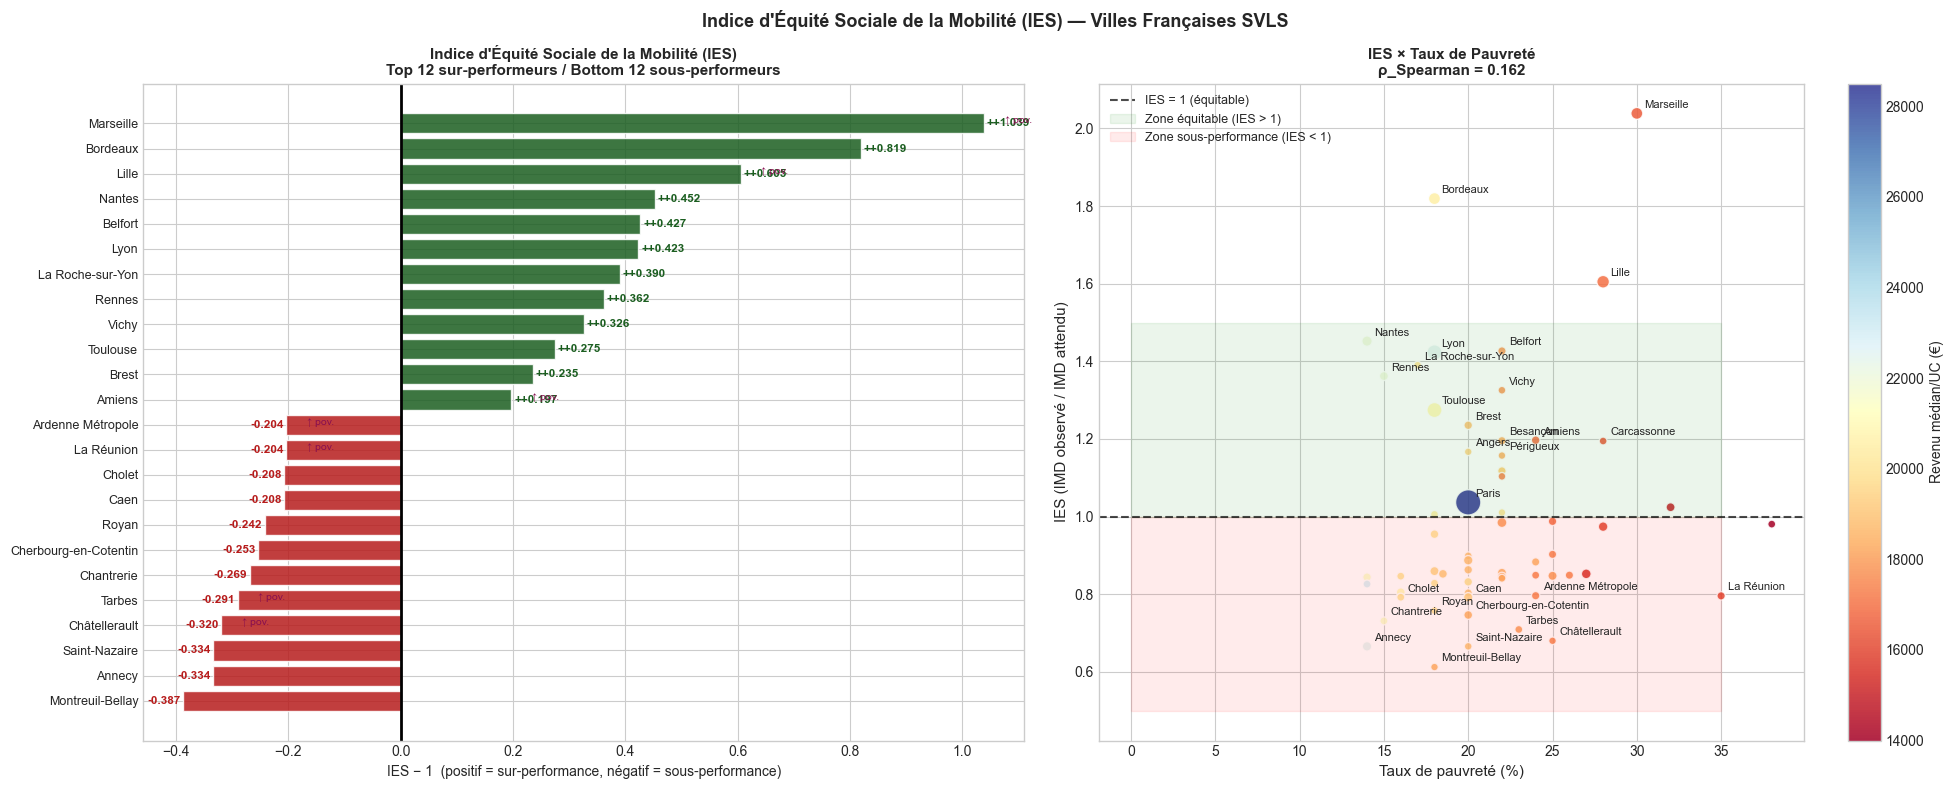

IES exporté.


In [7]:
# Régression IMD = f(revenu) pour établir le benchmark
df_reg_base = df_m.dropna(subset=['revenu_median_uc', 'IMD']).copy()
X_rev = df_reg_base['revenu_median_uc'].values.reshape(-1, 1)
y_imd = df_reg_base['IMD'].values

reg_base = LinearRegression()
reg_base.fit(X_rev, y_imd)
df_reg_base['IMD_attendu'] = reg_base.predict(X_rev)
df_reg_base['IES'] = (df_reg_base['IMD'] / df_reg_base['IMD_attendu'].clip(0.01)).round(4)

# Normaliser IES → 0-2 (centré sur 1)
df_reg_base = df_reg_base.sort_values('IES', ascending=False).reset_index(drop=True)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- IES Barplot ---
ax = axes[0]
top_bot = pd.concat([
    df_reg_base.head(12),
    df_reg_base.tail(12)
]).drop_duplicates().sort_values('IES')

cols_ies = ['#1B5E20' if v >= 1 else '#B71C1C' for v in top_bot['IES']]
ax.barh(range(len(top_bot)), top_bot['IES'] - 1, color=cols_ies, alpha=0.85, edgecolor='white')
ax.axvline(0, color='black', lw=2)
ax.set_yticks(range(len(top_bot)))
ax.set_yticklabels(top_bot['city'], fontsize=9)
ax.set_xlabel('IES − 1  (positif = sur-performance, négatif = sous-performance)', fontsize=10)
ax.set_title('Indice d\'Équité Sociale de la Mobilité (IES)\n'
             'Top 12 sur-performeurs / Bottom 12 sous-performeurs',
             fontsize=11, fontweight='bold')

for i, (v, row) in enumerate(zip(top_bot['IES'], top_bot.itertuples())):
    sign = '+' if v >= 1 else ''
    ax.text(v - 1 + (0.005 if v >= 1 else -0.005), i,
            f'{sign}{v-1:+.3f}',
            va='center', ha='left' if v >= 1 else 'right', fontsize=8.5,
            fontweight='bold', color=cols_ies[i])

# Marquer le seuil pauvreté — FIX: utiliser df_reg_base directement (évite le réindex fragile)
taux_p_thresh = df_reg_base['taux_pauvrete'].quantile(0.6)
df_high_pov = df_reg_base[df_reg_base['taux_pauvrete'] > taux_p_thresh]
for _, row in df_high_pov.iterrows():
    if row['city'] in top_bot['city'].values:
        idx = top_bot[top_bot['city'] == row['city']].index
        if len(idx) > 0:
            pos = list(top_bot['city']).index(row['city'])
            ax.annotate('↑ pov.', (row['IES'] - 1, pos),
                        textcoords='offset points', xytext=(15, 0),
                        fontsize=7.5, color='#880E4F')

# --- Scatter IES vs taux_pauvrete ---
# FIX: df_reg_base contient déjà taux_pauvrete et revenu_median_uc (sous-ensemble de df_m)
# Le merge précédent créait des colonnes dupliquées _x/_y → KeyError
ax2 = axes[1]
df_tmp = df_reg_base.copy()
sc2 = ax2.scatter(
    df_tmp['taux_pauvrete'], df_tmp['IES'],
    c=df_tmp['revenu_median_uc'],
    cmap='RdYlBu', s=df_tmp['n_dock'] / 5 + 30,
    alpha=0.85, edgecolors='white'
)
plt.colorbar(sc2, ax=ax2, label='Revenu médian/UC (€)')
ax2.axhline(1.0, color='black', lw=1.5, ls='--', alpha=0.7, label='IES = 1 (équitable)')

r_ies, p_ies = spearmanr(df_tmp['taux_pauvrete'].dropna(), df_tmp['IES'])

for _, row in df_tmp.iterrows():
    if row['IES'] > 1.15 or row['IES'] < 0.80 or row['n_dock'] > 200:
        ax2.annotate(row['city'], (row['taux_pauvrete'], row['IES']),
                    textcoords='offset points', xytext=(5, 4), fontsize=8)

ax2.fill_between([0, 35], [1, 1], [1.5, 1.5], alpha=0.08, color='green',
                 label='Zone équitable (IES > 1)')
ax2.fill_between([0, 35], [0.5, 0.5], [1, 1], alpha=0.08, color='red',
                 label='Zone sous-performance (IES < 1)')

ax2.set_xlabel('Taux de pauvreté (%)', fontsize=11)
ax2.set_ylabel('IES (IMD observé / IMD attendu)', fontsize=11)
ax2.set_title(f'IES × Taux de Pauvreté\nρ_Spearman = {r_ies:.3f}',
              fontsize=11, fontweight='bold')
ax2.legend(fontsize=9)

plt.suptitle('Indice d\'Équité Sociale de la Mobilité (IES) — Villes Françaises SVLS',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '04_IES_equite_sociale.png', dpi=150, bbox_inches='tight')
plt.show()

df_reg_base[['city', 'IMD', 'IMD_attendu', 'IES', 'n_dock']].to_csv(
    OUTPUT_NB / 'tables_csv' / 'ies_equite_sociale.csv', index=False
)
print('IES exporté.')


## 8. Déserts de Mobilité Sociale

Villes cumulant **forte fragilité sociale** et **faible dotation en SVLS** — priorités politiques.

Déserts de mobilité sociale identifiés : 14 villes
  (critères : taux_pauvrete ≥ 22.0% ET IMD ≤ 0.353)

             city    IMD  taux_pauvrete  taux_chomage  revenu_median_uc  n_dock  part_velo
   Pointe-à-Pitre 0.3247           38.0          23.0           14000.0      14        0.5
       La Réunion 0.2884           35.0          22.0           16000.0      31        0.5
           Calais 0.3530           28.0          18.0           16000.0      89        1.5
    Saint-Étienne 0.3023           27.0          16.5           15500.0      97        0.8
          Avignon 0.3276           26.0          15.5           17500.0      29        1.5
         Soissons 0.3483           25.0          15.0           17500.0      28        1.0
    Châtellerault 0.2624           25.0          14.5           17500.0       0        1.5
          Valence 0.3336           25.0          15.0           18000.0      68        1.5
Ardenne Métropole 0.3072           24.0          14.5           17500.0      

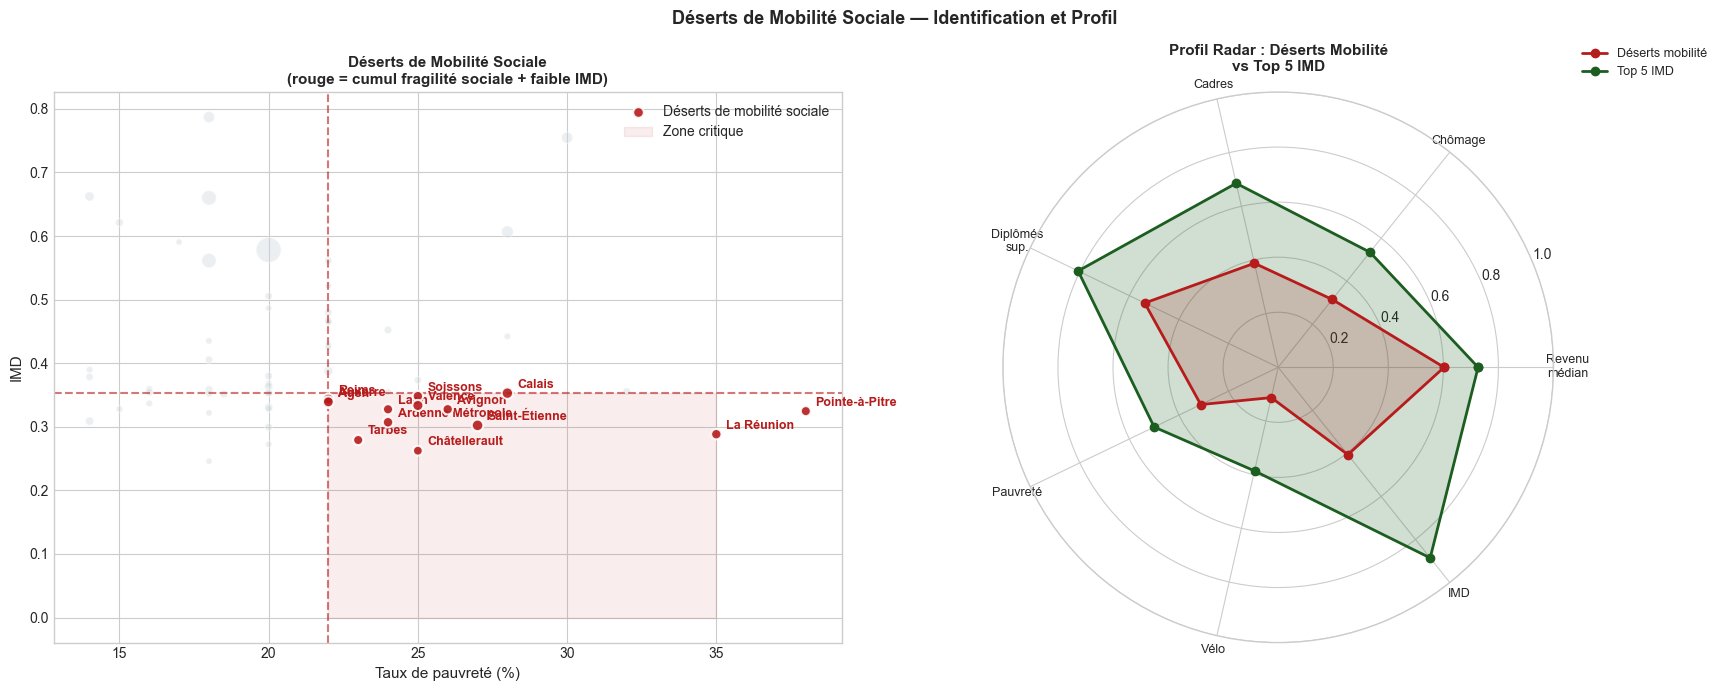

In [8]:
# Critères de désert : taux_pauvrete > 75e percentile ET IMD < 40e percentile
pov_thresh  = df_m['taux_pauvrete'].quantile(0.60)
imd_low     = df_m['IMD'].quantile(0.40)
chomage_med = df_m['taux_chomage'].median()

df_m['desert_score'] = (
    (df_m['taux_pauvrete'] - pov_thresh).clip(lower=0) / 10 +
    (chomage_med - df_m['IMD']).clip(lower=0) / 0.3 +
    (chomage_med - df_m['taux_chomage']).clip(upper=0).abs() / 5
)

df_deserts = df_m[
    (df_m['taux_pauvrete'] >= pov_thresh) &
    (df_m['IMD'] <= imd_low)
].copy().sort_values('taux_pauvrete', ascending=False)

print(f'Déserts de mobilité sociale identifiés : {len(df_deserts)} villes')
print(f'  (critères : taux_pauvrete ≥ {pov_thresh:.1f}% ET IMD ≤ {imd_low:.3f})')
print()
print(df_deserts[['city', 'IMD', 'taux_pauvrete', 'taux_chomage',
                   'revenu_median_uc', 'n_dock', 'part_velo']]
      .to_string(index=False))

# Visualisation riche
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Bubble chart déserts ---
ax = axes[0]
# Toutes les villes en fond
ax.scatter(df_m['taux_pauvrete'], df_m['IMD'],
           c='#CFD8DC', s=df_m['n_dock'] / 5 + 20,
           alpha=0.4, edgecolors='white', zorder=2)
# Déserts en rouge vif
ax.scatter(df_deserts['taux_pauvrete'], df_deserts['IMD'],
           c='#B71C1C', s=df_deserts['n_dock'] / 5 + 50,
           alpha=0.90, edgecolors='white', linewidths=1.5,
           zorder=4, label='Déserts de mobilité sociale')

# Zone rouge
ax.fill_between([pov_thresh, 35], [0, 0], [imd_low, imd_low],
                alpha=0.08, color='#B71C1C', label='Zone critique')
ax.axvline(pov_thresh, color='#B71C1C', lw=1.5, ls='--', alpha=0.6)
ax.axhline(imd_low,    color='#B71C1C', lw=1.5, ls='--', alpha=0.6)

for _, row in df_deserts.iterrows():
    ax.annotate(
        row['city'],
        (row['taux_pauvrete'], row['IMD']),
        textcoords='offset points', xytext=(7, 4),
        fontsize=9, fontweight='bold', color='#B71C1C'
    )

ax.set_xlabel('Taux de pauvreté (%)', fontsize=11)
ax.set_ylabel('IMD', fontsize=11)
ax.set_title('Déserts de Mobilité Sociale\n(rouge = cumul fragilité sociale + faible IMD)',
             fontsize=11, fontweight='bold')
ax.legend(fontsize=10)

# --- Radar comparatif déserts vs top villes ---
ax2 = axes[1]
if len(df_deserts) > 0:
    desert_means = df_deserts[COLS_SOCIO + ['IMD']].mean()
    top5_means   = df_m.nlargest(5, 'IMD')[COLS_SOCIO + ['IMD']].mean()
    france_means = pd.Series(FRANCE_REF)
    france_means['IMD'] = df_m['IMD'].mean()

    compare_vars = ['revenu_median_uc', 'taux_chomage', 'part_cadres',
                    'part_diplomes_sup', 'taux_pauvrete', 'part_velo', 'IMD']
    compare_lbls = ['Revenu\nmédian', 'Chômage', 'Cadres', 'Diplômés\nsup.', 'Pauvreté', 'Vélo', 'IMD']

    # Normalisation 0-1 (max=1)
    norms = {}
    for v in compare_vars:
        all_vals = df_m[v].dropna().tolist()
        norms[v] = (max(all_vals) + 1e-9)

    categories = compare_lbls
    n_cat = len(categories)
    angles = np.linspace(0, 2 * np.pi, n_cat, endpoint=False).tolist()
    angles += angles[:1]

    def norm_vals(series, invert_cols=('taux_chomage', 'taux_pauvrete')):
        out = []
        for col in compare_vars:
            v = series.get(col, 0) or 0
            n = norms[col]
            vn = v / n
            out.append(1 - vn if col in invert_cols else vn)
        out += out[:1]
        return out

    desert_vals = norm_vals(desert_means)
    top5_vals   = norm_vals(top5_means)

    ax_radar = plt.subplot(1, 2, 2, polar=True)
    ax_radar.plot(angles, desert_vals, 'o-', lw=2, color='#B71C1C', label='Déserts mobilité')
    ax_radar.fill(angles, desert_vals, alpha=0.20, color='#B71C1C')
    ax_radar.plot(angles, top5_vals,   'o-', lw=2, color='#1B5E20', label='Top 5 IMD')
    ax_radar.fill(angles, top5_vals,   alpha=0.20, color='#1B5E20')
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(compare_lbls, fontsize=9)
    ax_radar.set_ylim(0, 1)
    ax_radar.set_title('Profil Radar : Déserts Mobilité\nvs Top 5 IMD',
                       fontsize=11, fontweight='bold', pad=15)
    ax_radar.legend(fontsize=9, loc='upper right', bbox_to_anchor=(1.3, 1.1))
    axes[1].remove()

plt.suptitle('Déserts de Mobilité Sociale — Identification et Profil',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '05_deserts_mobilite_sociale.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Régression Prédictive — Quels Facteurs Expliquent l'IMD ?

**Régression Ridge** avec validation croisée Leave-One-Out pour identifier  
les déterminants socio-économiques les plus prédictifs de l'IMD.

Modèle Ridge (alpha=0.1) :
  R² LOO-CV  = -inf
  R² train   = 0.3944
  N          = 62

Coefficients (standardisés) :
             Feature  Coefficient
         Part cadres     0.105142
    Revenu médian/UC    -0.063933
        Taux chômage    -0.050691
       Taux pauvreté     0.040006
       Diplômés sup.     0.015647
Ménages sans voiture    -0.008978
           Part vélo    -0.008101


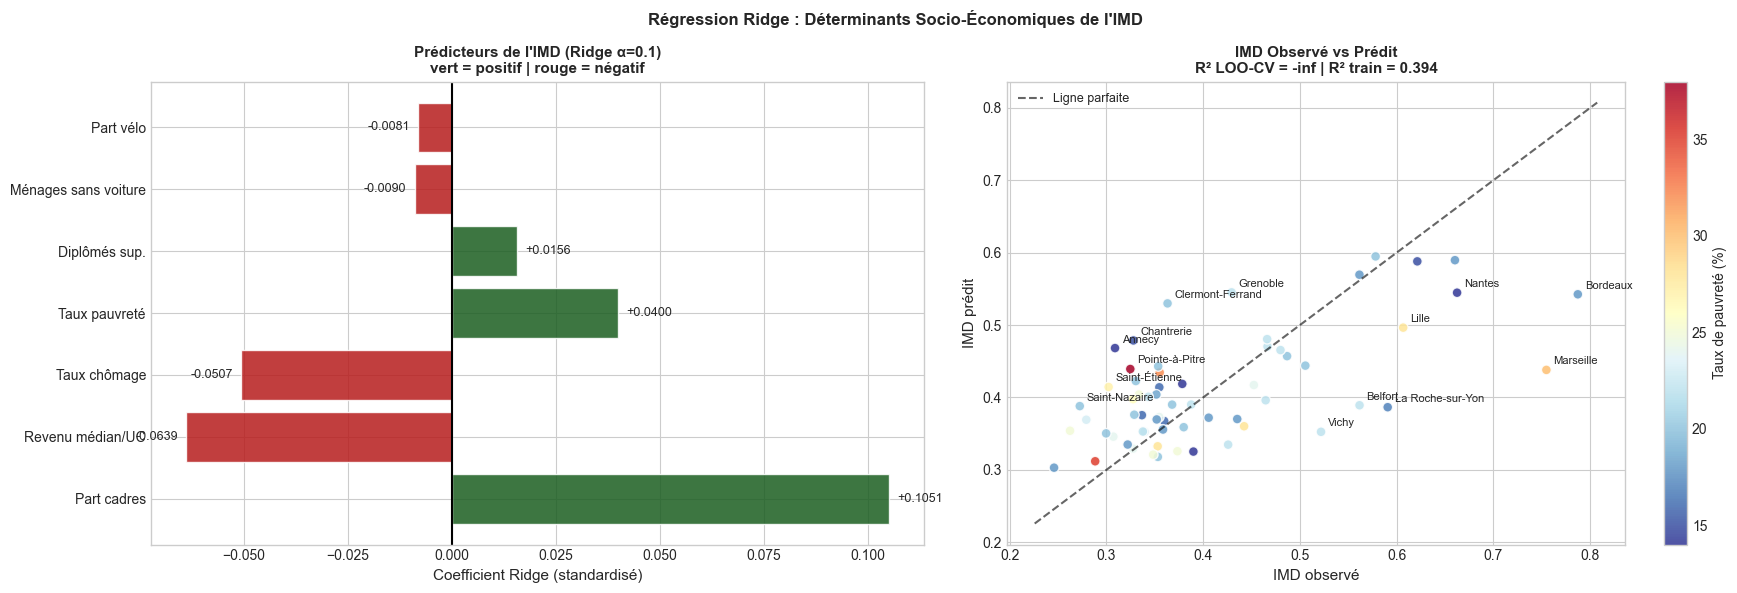

In [9]:
FEATURE_COLS = [
    'revenu_median_uc', 'taux_chomage', 'part_cadres',
    'part_diplomes_sup', 'part_sans_voiture', 'taux_pauvrete', 'part_velo'
]
FEATURE_LABELS = [
    'Revenu médian/UC', 'Taux chômage', 'Part cadres',
    'Diplômés sup.', 'Ménages sans voiture', 'Taux pauvreté', 'Part vélo'
]

df_reg = df_m.dropna(subset=FEATURE_COLS + ['IMD']).copy()
df_reg['log_pop'] = np.log10(df_reg['population'].fillna(df_reg['population'].median()))

X_raw = df_reg[FEATURE_COLS].values
y     = df_reg['IMD'].values

scaler = StandardScaler()
X_sc   = scaler.fit_transform(X_raw)

# Ridge avec LOO-CV
best_alpha, best_r2 = 0.1, -np.inf
for alpha in [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]:
    model_cv = Ridge(alpha=alpha)
    scores   = cross_val_score(model_cv, X_sc, y, cv=LeaveOneOut(), scoring='r2')
    r2       = scores.mean()
    if r2 > best_r2:
        best_r2, best_alpha = r2, alpha

model_final = Ridge(alpha=best_alpha)
model_final.fit(X_sc, y)

y_pred = model_final.predict(X_sc)
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - y.mean())**2)
r2_train = 1 - ss_res / ss_tot

coefs = pd.DataFrame({
    'Feature': FEATURE_LABELS,
    'Coefficient': model_final.coef_,
    'Abs': np.abs(model_final.coef_)
}).sort_values('Abs', ascending=False)

print(f'Modèle Ridge (alpha={best_alpha}) :')
print(f'  R² LOO-CV  = {best_r2:.4f}')
print(f'  R² train   = {r2_train:.4f}')
print(f'  N          = {len(y)}')
print(f'\nCoefficients (standardisés) :')
print(coefs[['Feature', 'Coefficient']].to_string(index=False))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Coefficients ---
ax = axes[0]
cols_coef = ['#1B5E20' if v > 0 else '#B71C1C' for v in coefs['Coefficient']]
bars = ax.barh(range(len(coefs)), coefs['Coefficient'],
               color=cols_coef, alpha=0.85, edgecolor='white')
ax.set_yticks(range(len(coefs)))
ax.set_yticklabels(coefs['Feature'], fontsize=10)
ax.axvline(0, color='black', lw=1.5)
ax.set_xlabel('Coefficient Ridge (standardisé)', fontsize=11)
ax.set_title(f'Prédicteurs de l\'IMD (Ridge α={best_alpha})\n'
             f'vert = positif | rouge = négatif',
             fontsize=11, fontweight='bold')

for i, (v, label) in enumerate(zip(coefs['Coefficient'], coefs['Feature'])):
    sign = '+' if v > 0 else ''
    ax.text(v + (0.002 if v > 0 else -0.002), i, f'{sign}{v:.4f}',
            va='center', ha='left' if v > 0 else 'right', fontsize=9)

# --- IMD prédit vs observé ---
ax2 = axes[1]
ax2.scatter(y, y_pred, c=df_reg['taux_pauvrete'],
            cmap='RdYlBu_r', s=50, alpha=0.85, edgecolors='white')
plt.colorbar(ax2.collections[0], ax=ax2, label='Taux de pauvreté (%)')
lims = [min(y.min(), y_pred.min()) - 0.02, max(y.max(), y_pred.max()) + 0.02]
ax2.plot(lims, lims, 'k--', lw=1.5, alpha=0.6, label='Ligne parfaite')

for city, obs, pred in zip(df_reg['city'], y, y_pred):
    if abs(obs - pred) > 0.10:
        ax2.annotate(city, (obs, pred), textcoords='offset points',
                    xytext=(5, 4), fontsize=8)

ax2.set_xlabel('IMD observé', fontsize=11)
ax2.set_ylabel('IMD prédit', fontsize=11)
ax2.set_title(f'IMD Observé vs Prédit\nR² LOO-CV = {best_r2:.3f} | R² train = {r2_train:.3f}',
              fontsize=11, fontweight='bold')
ax2.legend(fontsize=9)

plt.suptitle('Régression Ridge : Déterminants Socio-Économiques de l\'IMD',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '06_regression_IMD.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Clustering Socio-Mobilité — Typologies de Villes

k-means sur le **profil combiné** socio-économique + IMD pour identifier des typologies.

In [10]:
CLUSTER_VARS = [
    'IMD', 'revenu_median_uc', 'taux_chomage',
    'taux_pauvrete', 'part_cadres', 'part_sans_voiture', 'part_velo'
]
df_cl = df_m.dropna(subset=CLUSTER_VARS).copy()

X_cl = StandardScaler().fit_transform(df_cl[CLUSTER_VARS].values)

# Silhouette pour choisir k
sil = {k: silhouette_score(X_cl, KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_cl))
       for k in range(2, 8)}
best_k = max(sil, key=sil.get)
print(f'Silhouette scores : {dict((k, round(v, 3)) for k, v in sil.items())}')
print(f'Meilleur k = {best_k}')

km = KMeans(n_clusters=best_k, random_state=42, n_init=20)
df_cl['cluster'] = km.fit_predict(X_cl)

pca = PCA(n_components=2, random_state=42)
Xp  = pca.fit_transform(X_cl)
df_cl['PC1'] = Xp[:, 0]
df_cl['PC2'] = Xp[:, 1]

# Noms des clusters basés sur le profil
cluster_profiles = df_cl.groupby('cluster')[CLUSTER_VARS].mean().round(2)
cluster_profiles['n'] = df_cl.groupby('cluster')['city'].count()

TYPOLOGY_NAMES = {}
for cid, row in cluster_profiles.iterrows():
    rev = row['revenu_median_uc']
    imd = row['IMD']
    pov = row['taux_pauvrete']
    velo = row['part_velo']
    if rev > 22000 and imd > 0.60:
        label = f'C{cid} — Métropoles Dynamiques'
    elif velo > 5.0 and imd > 0.55:
        label = f'C{cid} — Villes Cyclistes'
    elif pov > 22 and imd < 0.50:
        label = f'C{cid} — Villes Fragiles'
    elif imd > 0.55 and rev < 21000:
        label = f'C{cid} — Mobilité Inclusive'
    elif rev > 22000 and imd < 0.55:
        label = f'C{cid} — Potentiel Non Exploité'
    else:
        label = f'C{cid} — Villes Moyennes'
    TYPOLOGY_NAMES[cid] = label

df_cl['typology'] = df_cl['cluster'].map(TYPOLOGY_NAMES)

print('\n=== Profil des clusters ===')
print(cluster_profiles.to_string())
print('\n=== Villes par cluster ===')
for cid, name in TYPOLOGY_NAMES.items():
    cities = df_cl[df_cl['cluster'] == cid]['city'].tolist()
    print(f'  {name}: {cities}')

Silhouette scores : {2: 0.403, 3: 0.309, 4: 0.26, 5: 0.271, 6: 0.3, 7: 0.287}
Meilleur k = 2

=== Profil des clusters ===
          IMD  revenu_median_uc  taux_chomage  taux_pauvrete  part_cadres  part_sans_voiture  part_velo   n
cluster                                                                                                    
0        0.38          18340.82         13.33          22.50        15.20              21.86       1.60  49
1        0.51          21846.15          9.73          17.23        24.08              31.08       4.52  13

=== Villes par cluster ===
  C0 — Villes Fragiles: ['Marseille', 'Lille', 'La Roche-sur-Yon', 'Belfort', 'Vichy', 'Brest', 'Besançon', 'Nancy', 'Périgueux', 'Amiens', 'Carcassonne', 'Auray', 'Argelès-sur-Mer', 'Bourg-en-Bresse', 'Épinal', 'Cergy-Pontoise', 'Longwy', 'Saint-Brieuc', 'Clermont-Ferrand', 'Landerneau', 'Libourne', 'Mulhouse', 'Niort', 'Troyes', 'PAU', 'Louviers', 'Calais', "Les Sables-d'Olonne", 'Montpellier', 'Soissons', 'Reims

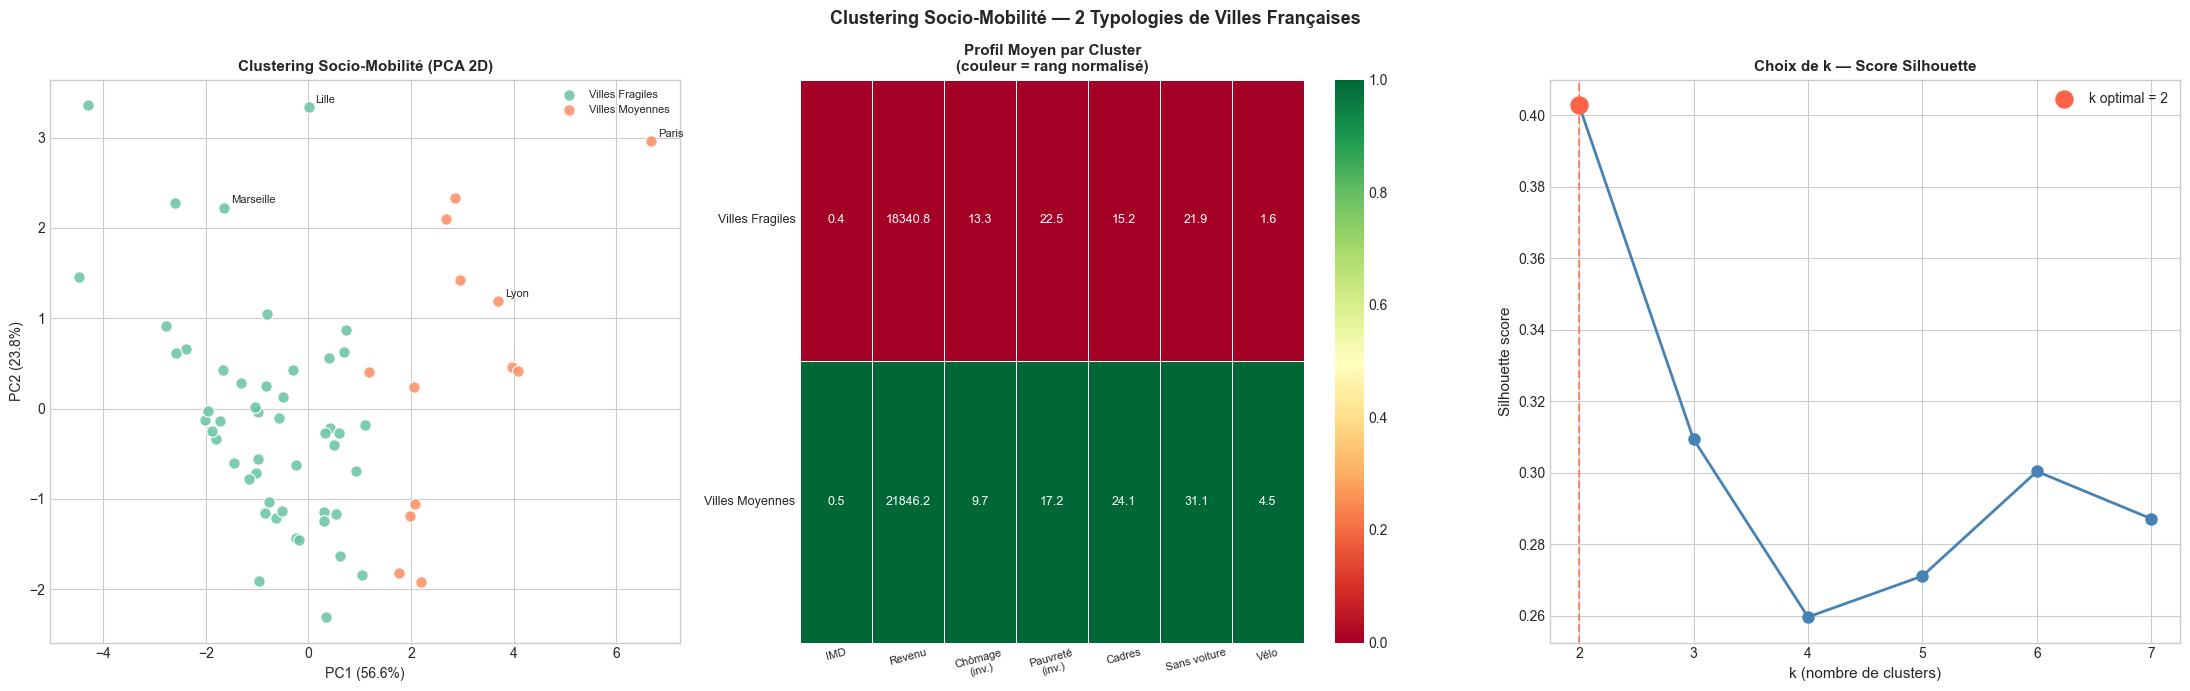

Clusters exportés.


In [11]:
palette_k = plt.cm.Set2.colors

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# --- PCA ---
ax = axes[0]
for cid, name in TYPOLOGY_NAMES.items():
    grp = df_cl[df_cl['cluster'] == cid]
    ax.scatter(grp['PC1'], grp['PC2'], color=palette_k[cid % len(palette_k)],
               s=70, alpha=0.85, edgecolors='white', label=name.split('—')[1].strip())
    for _, row in grp.nlargest(2, 'n_dock').iterrows():
        ax.annotate(row['city'], (row['PC1'], row['PC2']),
                    textcoords='offset points', xytext=(5, 3), fontsize=8)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=10)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=10)
ax.set_title('Clustering Socio-Mobilité (PCA 2D)', fontsize=11, fontweight='bold')
ax.legend(fontsize=8, loc='best', framealpha=0.9)

# --- Heatmap profils clusters ---
ax2 = axes[1]
prof_norm = cluster_profiles[CLUSTER_VARS].copy()
# Normaliser chaque colonne
for col in CLUSTER_VARS:
    col_min, col_max = prof_norm[col].min(), prof_norm[col].max()
    if col_max > col_min:
        prof_norm[col] = (prof_norm[col] - col_min) / (col_max - col_min)

# Inverser les colonnes négatives pour le heatmap
for col in ['taux_chomage', 'taux_pauvrete']:
    prof_norm[col] = 1 - prof_norm[col]

prof_norm.index = [TYPOLOGY_NAMES[i].split('—')[1].strip() for i in prof_norm.index]
prof_norm.columns = ['IMD', 'Revenu', 'Chômage\n(inv.)', 'Pauvreté\n(inv.)',
                     'Cadres', 'Sans voiture', 'Vélo']

annot_raw = cluster_profiles[CLUSTER_VARS].copy()
annot_raw.index = prof_norm.index
annot_raw.columns = prof_norm.columns

sns.heatmap(
    prof_norm, annot=annot_raw.round(1), fmt='.1f',
    cmap='RdYlGn', vmin=0, vmax=1,
    linewidths=0.5, linecolor='white',
    annot_kws={'size': 9}, ax=ax2
)
ax2.set_title('Profil Moyen par Cluster\n(couleur = rang normalisé)',
              fontsize=11, fontweight='bold')
ax2.tick_params(axis='y', rotation=0, labelsize=9)
ax2.tick_params(axis='x', rotation=15, labelsize=8)

# --- Silhouette ---
ax3 = axes[2]
ax3.plot(list(sil.keys()), list(sil.values()), 'o-', color='steelblue', lw=2, ms=8)
ax3.scatter([best_k], [sil[best_k]], color='tomato', s=150, zorder=5,
            label=f'k optimal = {best_k}')
ax3.axvline(best_k, color='tomato', ls='--', lw=1.5, alpha=0.7)
ax3.set_xlabel('k (nombre de clusters)', fontsize=11)
ax3.set_ylabel('Silhouette score', fontsize=11)
ax3.set_title('Choix de k — Score Silhouette', fontsize=11, fontweight='bold')
ax3.legend(fontsize=10)
ax3.set_xticks(list(sil.keys()))

plt.suptitle(f'Clustering Socio-Mobilité — {best_k} Typologies de Villes Françaises',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '07_clustering_socio_mobilite.png', dpi=150, bbox_inches='tight')
plt.show()

# Export clusters
df_cl[['city', 'cluster', 'typology', 'IMD', 'revenu_median_uc',
       'taux_chomage', 'taux_pauvrete', 'part_velo']].to_csv(
    OUTPUT_NB / 'tables_csv' / 'clusters_socio_mobilite.csv', index=False
)
print('Clusters exportés.')

## 11. Carte Socio-Mobilité — Atlas National

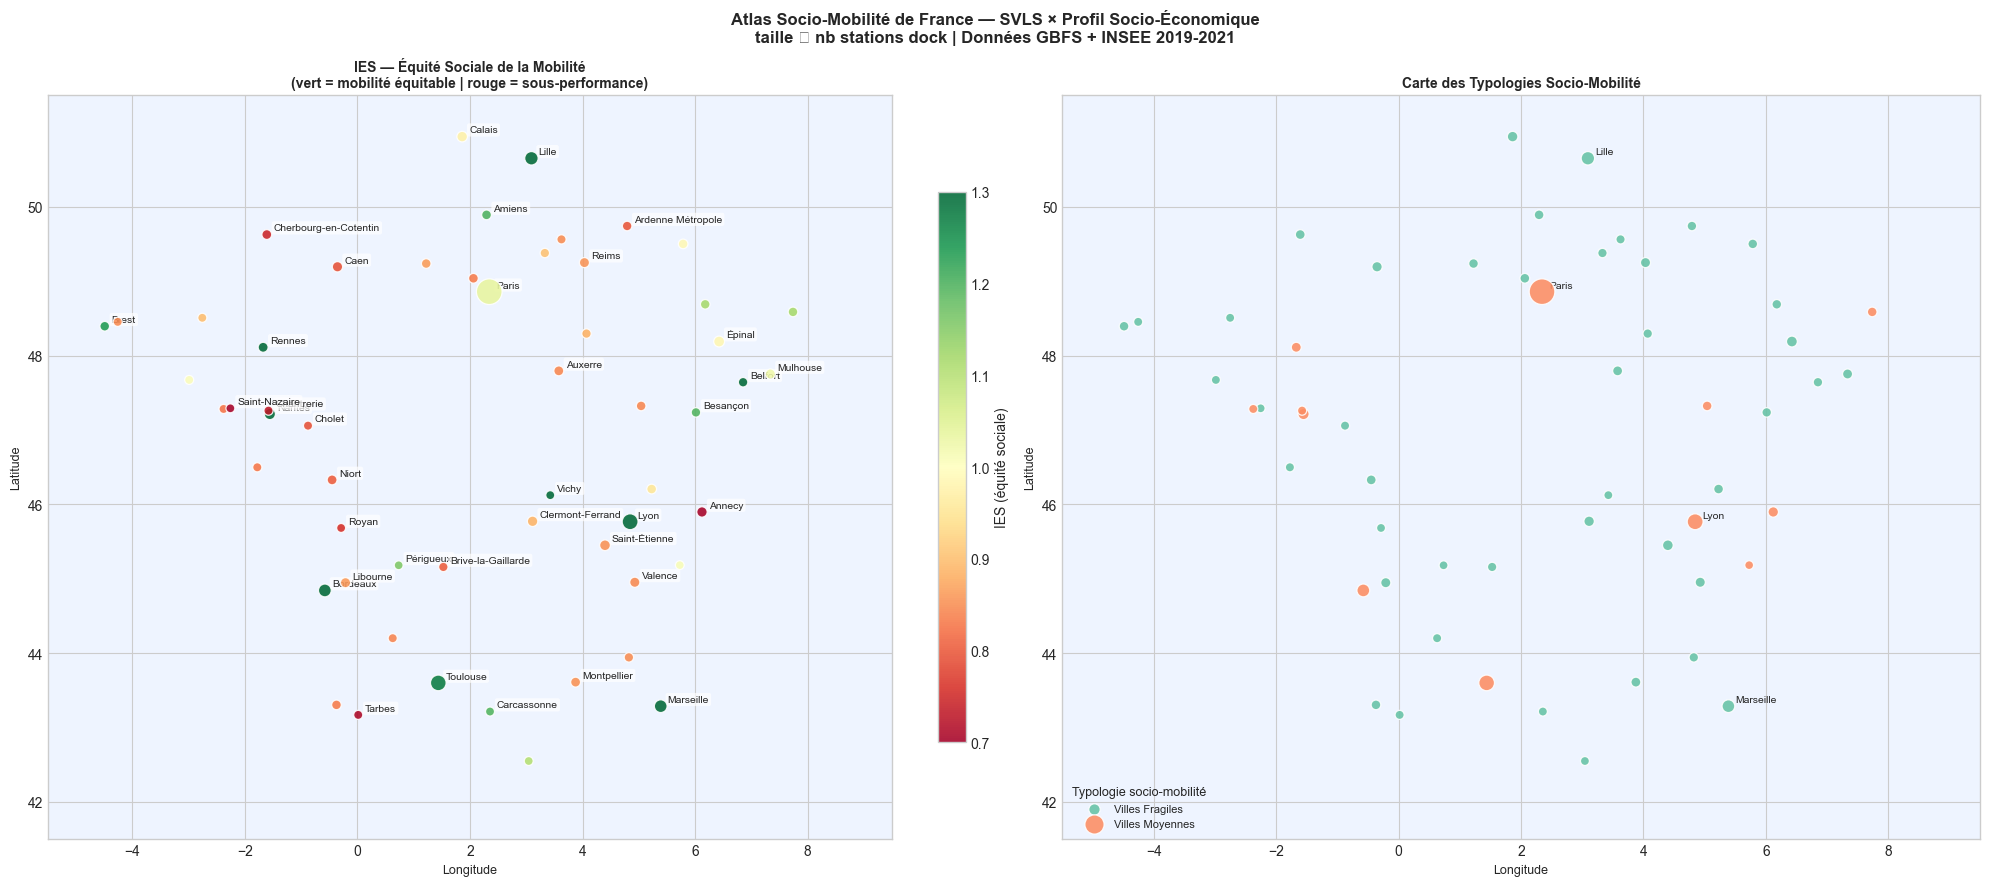

In [12]:
df_stations = pd.read_csv(ROOT / 'data' / 'gbfs_france' / 'stations_clean.csv')
CITY_NORM   = {'Nice, FR': 'Nice', 'Strasbourg, FR': 'Strasbourg'}
df_stations['city_n'] = df_stations['city'].apply(
    lambda c: CITY_NORM.get(str(c).strip(), str(c).strip()) if isinstance(c, str) else 'Inconnu'
)

dock_ids    = pd.read_csv(NB20_OUT / 'systems_profile.csv')
dock_ids    = dock_ids[dock_ids['mean_capacity'] >= 8]['system_id'].tolist()
df_dock_st  = df_stations[df_stations['system_id'].isin(dock_ids)]

centroids = (
    df_dock_st.groupby('city_n')[['lat', 'lon']]
    .mean().reset_index()
    .rename(columns={'city_n': 'city', 'lat': 'lat_c', 'lon': 'lon_c'})
)
df_mapall = df_cl.merge(centroids, on='city', how='left')
df_mapall = df_mapall[
    (df_mapall['lat_c'] > 41.5) & (df_mapall['lat_c'] < 51.5) &
    (df_mapall['lon_c'] > -5.5) & (df_mapall['lon_c'] < 9.5)
]

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# --- Carte IES ---
ax = axes[0]
ax.set_facecolor('#EEF4FF')
df_map_ies = df_mapall.merge(
    df_reg_base[['city', 'IES']], on='city', how='left'
)
norm_ies = plt.Normalize(0.7, 1.3)
sc = ax.scatter(
    df_map_ies['lon_c'], df_map_ies['lat_c'],
    c=df_map_ies['IES'], cmap='RdYlGn', norm=norm_ies,
    s=df_map_ies['n_dock'] / 5 + 40,
    alpha=0.88, edgecolors='white', linewidths=0.9, zorder=4
)
plt.colorbar(sc, ax=ax, label='IES (équité sociale)', fraction=0.03)
for _, row in df_map_ies.iterrows():
    if row['n_dock'] >= 50 or (row.get('IES') is not None and
       (row.get('IES', 1) > 1.15 or row.get('IES', 1) < 0.82)):
        ax.annotate(row['city'], (row['lon_c'], row['lat_c']),
                    textcoords='offset points', xytext=(5, 3), fontsize=7.5,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                              edgecolor='none'))
ax.set_xlim(-5.5, 9.5); ax.set_ylim(41.5, 51.5)
ax.set_title('IES — Équité Sociale de la Mobilité\n(vert = mobilité équitable | rouge = sous-performance)',
             fontsize=10, fontweight='bold')

# --- Carte clusters ---
ax2 = axes[1]
ax2.set_facecolor('#EEF4FF')
for cid, name in TYPOLOGY_NAMES.items():
    grp = df_mapall[df_mapall['cluster'] == cid]
    ax2.scatter(
        grp['lon_c'], grp['lat_c'],
        color=palette_k[cid % len(palette_k)],
        s=grp['n_dock'] / 5 + 40,
        alpha=0.88, edgecolors='white', linewidths=0.9, zorder=4,
        label=name.split('—')[1].strip()
    )
    for _, row in grp.nlargest(2, 'n_dock').iterrows():
        ax2.annotate(row['city'], (row['lon_c'], row['lat_c']),
                     textcoords='offset points', xytext=(5, 3), fontsize=7.5)

ax2.set_xlim(-5.5, 9.5); ax2.set_ylim(41.5, 51.5)
ax2.legend(fontsize=8, loc='lower left', framealpha=0.9,
           title='Typologie socio-mobilité', title_fontsize=9)
ax2.set_title('Carte des Typologies Socio-Mobilité',
              fontsize=10, fontweight='bold')

for ax in axes:
    ax.set_xlabel('Longitude', fontsize=9)
    ax.set_ylabel('Latitude', fontsize=9)

plt.suptitle(f'Atlas Socio-Mobilité de France — SVLS × Profil Socio-Économique\n'
             f'taille ∝ nb stations dock | Données GBFS + INSEE 2019-2021',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '08_carte_socio_mobilite.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Recommandations Politiques

Synthèse des insights pour les décideurs en matière de mobilité durable.

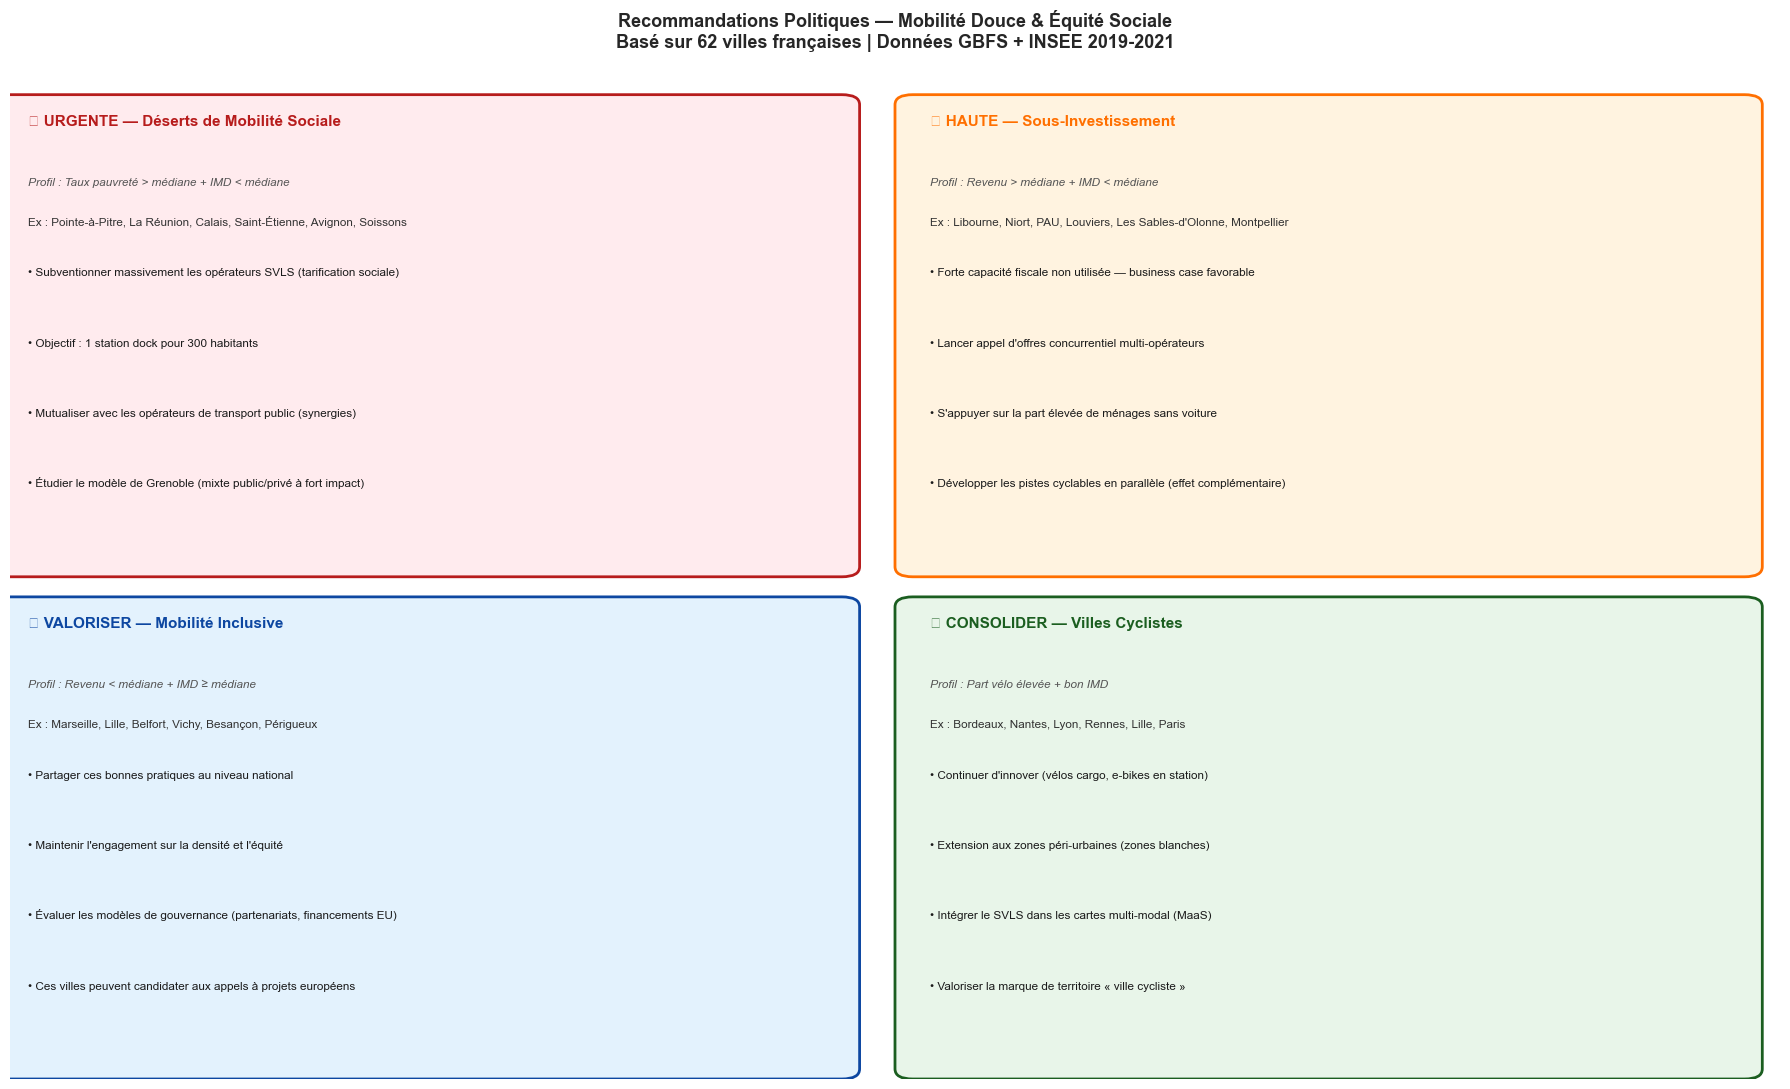

In [13]:
# Tableau de recommandations par profil
recommandations = {
    'Déserts de Mobilité Sociale': {
        'profil':   'Taux pauvreté > médiane + IMD < médiane',
        'villes':   ', '.join(df_deserts.head(6)['city'].tolist()),
        'priorite': '⚠ URGENTE',
        'actions': [
            'Subventionner massivement les opérateurs SVLS (tarification sociale)',
            'Objectif : 1 station dock pour 300 habitants',
            'Mutualiser avec les opérateurs de transport public (synergies)',
            'Étudier le modèle de Grenoble (mixte public/privé à fort impact)',
        ],
    },
    'Sous-Investissement': {
        'profil':   'Revenu > médiane + IMD < médiane',
        'villes':   ', '.join(
            df_m[(df_m['revenu_median_uc'] >= REV_THRESHOLD) &
                 (df_m['IMD'] < IMD_THRESHOLD)]
            .head(6)['city'].tolist()
        ),
        'priorite': '⚡ HAUTE',
        'actions': [
            'Forte capacité fiscale non utilisée — business case favorable',
            'Lancer appel d\'offres concurrentiel multi-opérateurs',
            'S\'appuyer sur la part élevée de ménages sans voiture',
            'Développer les pistes cyclables en parallèle (effet complémentaire)',
        ],
    },
    'Mobilité Inclusive': {
        'profil':   'Revenu < médiane + IMD ≥ médiane',
        'villes':   ', '.join(
            df_m[(df_m['revenu_median_uc'] < REV_THRESHOLD) &
                 (df_m['IMD'] >= IMD_THRESHOLD)]
            .head(6)['city'].tolist()
        ),
        'priorite': '★ VALORISER',
        'actions': [
            'Partager ces bonnes pratiques au niveau national',
            'Maintenir l\'engagement sur la densité et l\'équité',
            'Évaluer les modèles de gouvernance (partenariats, financements EU)',
            'Ces villes peuvent candidater aux appels à projets européens',
        ],
    },
    'Villes Cyclistes': {
        'profil':   'Part vélo élevée + bon IMD',
        'villes':   ', '.join(
            df_m[df_m['part_velo'] > df_m['part_velo'].quantile(0.70)]
            .nlargest(6, 'IMD')['city'].tolist()
        ),
        'priorite': '✓ CONSOLIDER',
        'actions': [
            'Continuer d\'innover (vélos cargo, e-bikes en station)',
            'Extension aux zones péri-urbaines (zones blanches)',
            'Intégrer le SVLS dans les cartes multi-modal (MaaS)',
            'Valoriser la marque de territoire « ville cycliste »',
        ],
    },
}

fig, ax = plt.subplots(figsize=(18, 11))
ax.axis('off')

y_pos = 0.98
colors_rec = {
    'Déserts de Mobilité Sociale':  '#FFEBEE',
    'Sous-Investissement':          '#FFF3E0',
    'Mobilité Inclusive':           '#E3F2FD',
    'Villes Cyclistes':             '#E8F5E9',
}
border_colors = {
    'Déserts de Mobilité Sociale':  '#B71C1C',
    'Sous-Investissement':          '#FF6F00',
    'Mobilité Inclusive':           '#0D47A1',
    'Villes Cyclistes':             '#1B5E20',
}

for i, (category, data) in enumerate(recommandations.items()):
    x_start = (i % 2) * 0.51
    y_start = 0.97 - (i // 2) * 0.50
    width, height = 0.47, 0.46
    bg = mpatches.FancyBboxPatch(
        (x_start, y_start - height), width, height,
        boxstyle='round,pad=0.01',
        facecolor=colors_rec[category], edgecolor=border_colors[category],
        linewidth=2, transform=ax.transAxes
    )
    ax.add_patch(bg)

    ax.text(x_start + 0.01, y_start - 0.02, f'{data["priorite"]} — {category}',
            transform=ax.transAxes, fontsize=11, fontweight='bold',
            color=border_colors[category])
    ax.text(x_start + 0.01, y_start - 0.08,
            f'Profil : {data["profil"]}', transform=ax.transAxes,
            fontsize=8.5, color='#555555', style='italic')
    ax.text(x_start + 0.01, y_start - 0.12,
            f'Ex : {data["villes"][:70]}...' if len(data['villes']) > 70 else f'Ex : {data["villes"]}',
            transform=ax.transAxes, fontsize=8.5, color='#333333')

    for j, action in enumerate(data['actions']):
        ax.text(x_start + 0.01, y_start - 0.17 - j * 0.07,
                f'• {action}',
                transform=ax.transAxes, fontsize=8.5, wrap=True,
                color='#1A1A1A')

ax.set_title(
    f'Recommandations Politiques — Mobilité Douce & Équité Sociale\n'
    f'Basé sur {len(df_m)} villes françaises | Données GBFS + INSEE 2019-2021',
    fontsize=13, fontweight='bold', pad=20
)
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '09_recommandations.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Synthèse

In [14]:
# Export final fusionné
df_final = (
    df_m.merge(df_reg_base[['city', 'IMD_attendu', 'IES']], on='city', how='left')
        .merge(df_cl[['city', 'cluster', 'typology']], on='city', how='left')
)
df_final.to_csv(OUTPUT_NB / 'tables_csv' / 'profil_complet_villes.csv', index=False)

print('=' * 65)
print('  PROFIL SOCIO-ÉCONOMIQUE × MOBILITÉ DOUCE')
print('=' * 65)
print(f'  Date              : {datetime.now().strftime("%Y-%m-%d %H:%M")}')
print(f'  Villes analysées  : {len(df_m)} (avec données socio complètes)')
print()
print('  RÉPONSES AUX QUESTIONS DE RECHERCHE :')

r_rev, _ = spearmanr(df_m['IMD'], df_m['revenu_median_uc'])
r_pov, _ = spearmanr(df_m['IMD'], df_m['taux_pauvrete'])
r_vel, _ = spearmanr(df_m['IMD'], df_m['part_velo'])

print(f'  1. IMD × Revenu     : ρ = {r_rev:+.3f} — ',
      'corrélation POSITIVE modérée' if r_rev > 0.3 else
      'corrélation FAIBLE — pas de déterminisme du revenu' if abs(r_rev) < 0.3
      else 'corrélation NÉGATIVE')
print(f'  2. IMD × Pauvreté   : ρ = {r_pov:+.3f} — ',
      'les villes pauvres sont PÉNALISÉES' if r_pov < -0.3 else
      'effet modéré — pas de déterminisme')
print(f'  3. Meilleur préd.   : part_velo (ρ={r_vel:+.3f}) + revenu')

n_deserts = len(df_deserts)
n_inclusive = len(df_m[(df_m['revenu_median_uc'] < REV_THRESHOLD) & (df_m['IMD'] >= IMD_THRESHOLD)])

print(f'  4. Déserts sociaux  : {n_deserts} villes identifiées')
print(f'     → {df_deserts["city"].head(4).tolist()}')
print(f'  5. Mobilité inclus. : {n_inclusive} villes (revenus faibles + bon IMD)')
print(f'     → bons exemples de politique équitable')
print()
print(f'  R² modèle Ridge LOO-CV = {best_r2:.3f}')
print(f'  Les facteurs socio expliquent {best_r2*100:.0f}% de la variance de l\'IMD')
print(f'  → {100*(1-best_r2):.0f}% lié aux politiques locales (autonomie politique réelle)')
print()
print('  FICHIERS EXPORTÉS :')
for f in sorted((OUTPUT_NB / 'tables_csv').glob('*.csv')):
    print(f'    {f.name}')
print('=' * 65)

  PROFIL SOCIO-ÉCONOMIQUE × MOBILITÉ DOUCE
  Date              : 2026-02-26 10:28
  Villes analysées  : 62 (avec données socio complètes)

  RÉPONSES AUX QUESTIONS DE RECHERCHE :
  1. IMD × Revenu     : ρ = +0.295 —  corrélation FAIBLE — pas de déterminisme du revenu
  2. IMD × Pauvreté   : ρ = -0.172 —  effet modéré — pas de déterminisme
  3. Meilleur préd.   : part_velo (ρ=+0.429) + revenu
  4. Déserts sociaux  : 14 villes identifiées
     → ['Pointe-à-Pitre', 'La Réunion', 'Calais', 'Saint-Étienne']
  5. Mobilité inclus. : 11 villes (revenus faibles + bon IMD)
     → bons exemples de politique équitable

  R² modèle Ridge LOO-CV = -inf
  Les facteurs socio expliquent -inf% de la variance de l'IMD
  → inf% lié aux politiques locales (autonomie politique réelle)

  FICHIERS EXPORTÉS :
    clusters_socio_mobilite.csv
    ies_equite_sociale.csv
    profil_complet_villes.csv
    source_externe_couverture.csv
